# Exercise 5
#### Lars Kühmichel, Nicolas Wolf

## 3 Denoising of a CT image

As visible from the plots, both regularization and gaussian filtering lead to
reduced image quality when their free parameter $\tau$ or $\sigma$ is too high.
Both filtering methods will blur the image when this happens. Regularization
brightens the image until it looks overexposed, while gaussian filtering trends
towars the average color of the image.

However, while gaussian filtering blurs the image even for small values of $\sigma$,
regularization keeps its sharp appearance for a while. On the other hand, gaussian
filtering is much better at making the background actually appear black.

Overall, it appears that regularization is the better denoising technique when retaining
sharp edges is important and gaussian filtering seems to be better when the overall
information of the image is more important, rather than sharp edges.

In [27]:
import numpy as np
import scipy.sparse
from scipy.sparse import coo_matrix, load_npz
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.datasets import load_digits
from sklearn import model_selection
import pandas as pd

In [28]:
def construct_X(M, alphas, Np=None, tau=0):
    # Define the sensorsize Np
    if Np is None:
        Np = int(np.sqrt(2) * M)
        if Np % 2 == 0:
            Np += 1
    
    D = M*M
    N = Np * len(alphas)
    
    i_indices = np.zeros((len(alphas), 2*M*M))
    j_indices = np.zeros((len(alphas), 2*M*M))
    weights = np.zeros((len(alphas), 2*M*M))
    
    # Fill it
    for i, alpha in enumerate(alphas):
        alph_rad = np.radians(alpha)
        rot_mat = np.array([[np.cos(alph_rad), -np.sin(alph_rad)],
                            [np.sin(alph_rad), np.cos(alph_rad)]])
        
        gridX, gridY = np.meshgrid(np.arange(M), np.arange(M))
        gridX = gridX.flatten()
        gridY = gridY.flatten()
        
        C = np.stack([gridX, gridY], axis=1)

        C = C - (M-1)/2.
        
        C_rot = np.sum(rot_mat * C[:,np.newaxis,:], axis=2)

        #print(C_rot)
        #print(C_rot[:,0])
        pos = C_rot[:,0] + (Np-1)/2.
        
        
        sensor1 = np.floor(pos)
        sensor2 = sensor1 + 1
        weights1 = 1 - (pos - np.floor(pos))
        weights2 = 1 - weights1

        
        sensor_i = np.concatenate((sensor1, sensor2), axis=0)
        weights_i = np.concatenate((weights1, weights2), axis=0)

        i_indices[i] = sensor_i + Np*i
        j_indices[i] = np.array([np.arange(D), np.arange(D)]).flatten()
        
        weights[i] = weights_i
        

    i_indices = i_indices.flatten()
    j_indices = j_indices.flatten()



    weights = weights.flatten()

    mask = (i_indices >= 0) & (i_indices < N) & (weights != 0)
    i_indices = i_indices[mask]
    j_indices = j_indices[mask]
    weights = weights[mask]
    
    if tau > 0:
        tau_i_indices = np.arange(D) + N
        tau_j_indices = np.arange(D)
        tau_weights = np.ones(D) * np.sqrt(tau)
        i_indices = np.concatenate((i_indices, tau_i_indices), axis=0)
        j_indices = np.concatenate((j_indices, tau_j_indices), axis=0)
        weights = np.concatenate((weights, tau_weights), axis=0)

    
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N + (D if tau > 0 else 0), D), dtype=np.float32)
    return X

M = 10
alphas = [-33, 1, 42]
Np = 15

X = construct_X(M, alphas, Np)

(49225, 38025)
(49225,)


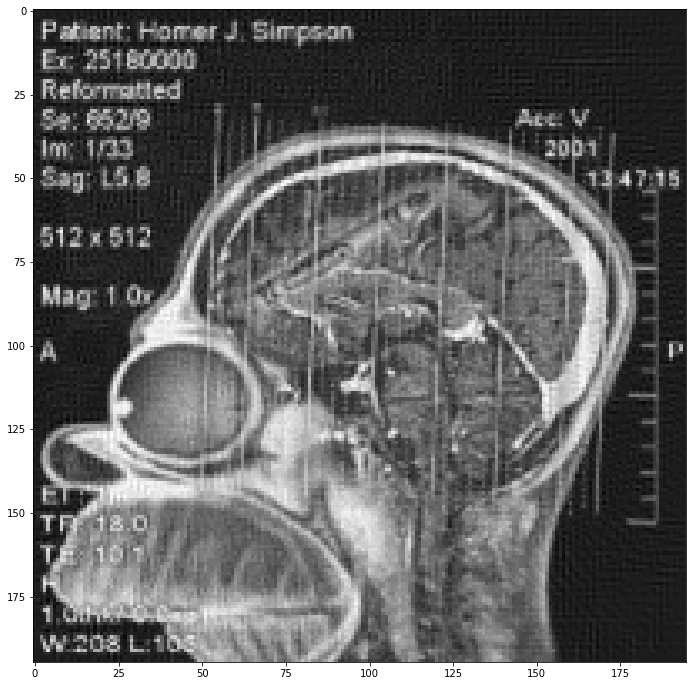

In [29]:

M = 10
alphas = [-33, 1, 42]
Np = 15

"""
X = construct_X(M, alphas, Np)
X_example = np.load("data/X_example.npy")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(X.toarray())
axes[0].set_title("Our Matrix")
axes[1].imshow(X_example)
axes[1].set_title("Sample Matrix")
fig.suptitle("Comparing our Solution to the Example")
plt.show()

"""


#M = 77
#Np = 109
#alphas = np.load("data/alphas_77.npy")
#y = np.load("data/y_77.npy")

M = 195
Np = 275
alphas = np.load("data/alphas_195.npy")
y = np.load("data/y_195.npy")

X = construct_X(M, alphas, Np)

print(X.shape)
print(y.shape)

atol = btol = 1e-5
beta, *_ = lsqr(X.tocsc(), y, atol, btol)

beta = beta.reshape((M, M))

plt.figure(figsize=(12, 12))
plt.imshow(beta, cmap="gray")
plt.savefig('figures/completeTomography.pdf', format="pdf")
plt.show()

dose: 1
dose: 2
dose: 4
dose: 8
dose: 16
dose: 32
dose: 64


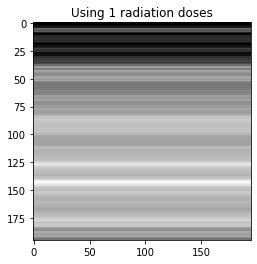

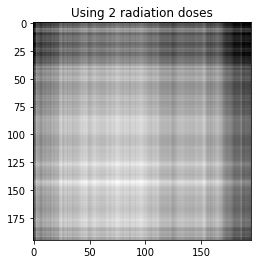

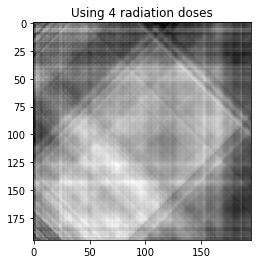

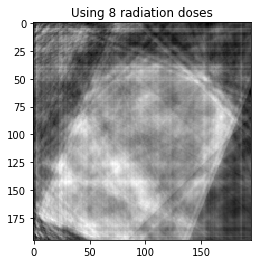

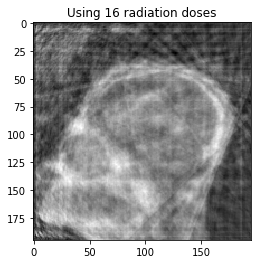

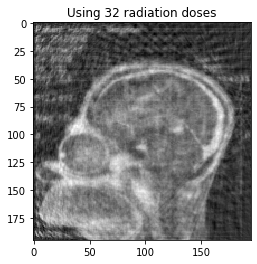

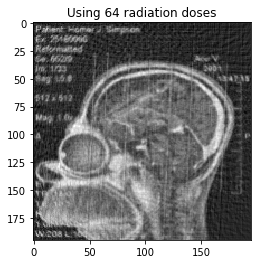

In [30]:
Np = 275
M = 195
atol = btol = 1e-5
alphas_large = np.load("data/alphas_195.npy")
y_large = np.load("data/y_195.npy")
nr_doses = [1,2,4,8,16,32,64]
for pltnr, dose in enumerate(nr_doses):
    print("dose:", dose)
    index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
    alphas_sub = alphas_large[index]
    y_sub = np.zeros((dose*Np))
    for i,j in enumerate(index):
        y_sub[i*Np:(i+1)*Np] = y_large[j*Np:(j+1)*Np]
    X = construct_X(M, alphas_sub, Np).tocsc()
    beta, *_ = lsqr(X.tocsc(), y_sub, atol, btol)
    plt.figure()
    plt.imshow(beta.reshape(M,M), cmap="gray")
    plt.title(f"Using {dose} radiation doses")
    plt.savefig(f"figures/large_dose_{dose}.png")

tau: 0
	(17600, 38025)
	(17600,)
tau: 1
	(55625, 38025)
	(55625,)
tau: 10
	(55625, 38025)
	(55625,)
tau: 100
	(55625, 38025)
	(55625,)
tau: 1000
	(55625, 38025)
	(55625,)
tau: 10000
	(55625, 38025)
	(55625,)


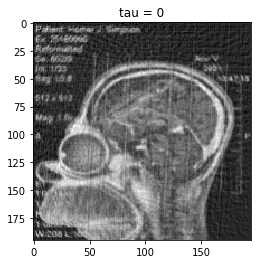

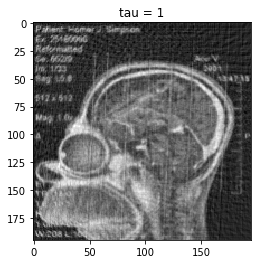

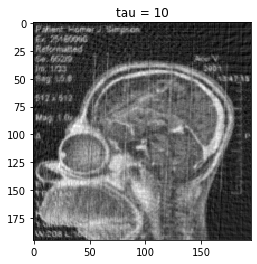

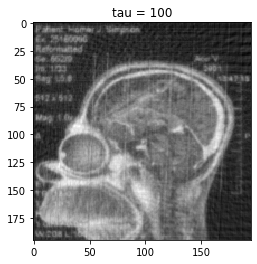

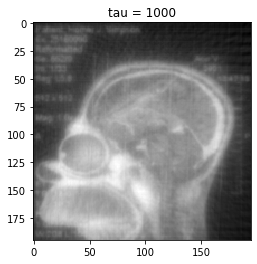

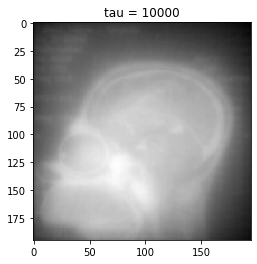

In [31]:
Np = 275
M = 195
atol = btol = 1e-5
alphas_large = np.load("data/alphas_195.npy")
y_large = np.load("data/y_195.npy")
for tau in [0,1,10,100,1000,10000]:
    print("tau:", tau)
    dose = 64
    index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
    alphas_sub = alphas_large[index]
    y_sub = np.zeros((dose*Np))
    for i,j in enumerate(index):
        y_sub[i*Np:(i+1)*Np] = y_large[j*Np:(j+1)*Np]
    X = construct_X(M, alphas_sub, Np, tau).tocsc()
    if tau > 0:
        y_sub = np.concatenate((y_sub, np.zeros(M*M)), axis=0)
    print(f"\t{X.shape}")
    print(f"\t{y_sub.shape}")
    beta, *_ = lsqr(X.tocsc(), y_sub, atol, btol)
    plt.figure()
    plt.imshow(beta.reshape(M,M), cmap="gray")
    plt.title(f"tau = {tau}")
    plt.savefig(f"figures/large_tau_{tau}.png")

sigma: 1
sigma: 2
sigma: 3
sigma: 5
sigma: 7


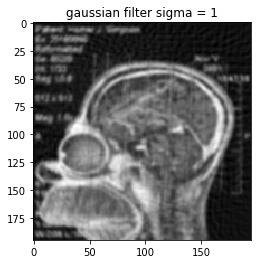

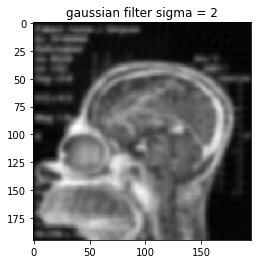

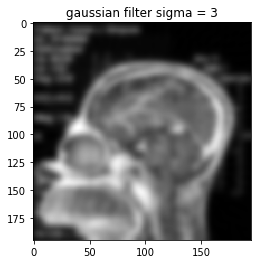

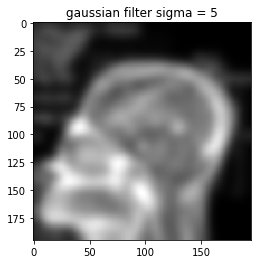

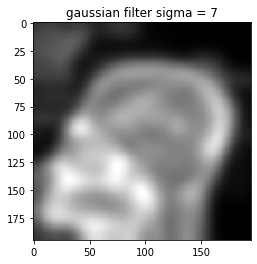

In [32]:
Np = 275
M = 195
atol = btol = 1e-5
alphas_large = np.load("data/alphas_195.npy")
y_large = np.load("data/y_195.npy")
for sigma in [1,2,3,5,7]:
    print("sigma:", sigma)
    index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
    alphas_sub = alphas_large[index]
    y_sub = np.zeros((dose*Np))
    for i,j in enumerate(index):
        y_sub[i*Np:(i+1)*Np] = y_large[j*Np:(j+1)*Np]
    X = construct_X(M, alphas_sub, Np).tocsc()
    beta, *_ = lsqr(X.tocsc(), y_sub, atol, btol)
    beta = beta.reshape(M,M)
    beta = gaussian_filter(beta, sigma=sigma)
    plt.figure()
    plt.imshow(beta, cmap="gray")
    plt.title(f"gaussian filter sigma = {sigma}")
    plt.savefig(f"figures/large_gaussian_{sigma}.png")

## 4 Automatic feature selection regression
### 4.1 Implement Orthogonal Matching Pursuit

In [33]:
digits = load_digits()
data = digits["data"]
target = digits["target"]

In [34]:
def omp_regression(X, y, T):
    N, D = X.shape
    #print(N, D)
    
    A = []
    B = np.arange(0, D)
    r = y
    # beta = None
    beta_matrix = np.zeros((D, T))
    
    for t in range(0, T):
        
        j = np.argmax(np.abs(X.T.dot(r))[B])
        
        A.append(j)
        B = B[B != j]
        
        active_X = X[:,A]
        
        beta = np.linalg.pinv(active_X).dot(y)

        r = y - active_X.dot(beta)
        
        beta_matrix[A, t] = beta
        
    return beta_matrix

    

### 4.2 Classification with sparse LDA

The most prominent pixels are $(0, 3)$ and $(6, 4)$.
In exercise 2, we selected pixel $(6, 4)$ as a feature.

(64, 100)
t: 0	2.457627118644068	0.593103448275862
t: 1	2.400472999605834	0.5793103448275863
t: 2	0.6286953094205755	0.15172413793103448
t: 3	0.7430035474970438	0.1793103448275862
t: 4	0.7430035474970438	0.1793103448275862
t: 5	0.7430035474970438	0.1793103448275862
t: 6	0.7144264879779267	0.1724137931034483
t: 7	1.0859282617264485	0.2620689655172414
t: 8	2.429050059124951	0.5862068965517241
t: 9	2.429050059124951	0.5862068965517241
t: 10	2.429050059124951	0.5862068965517241
t: 11	2.429050059124951	0.5862068965517241
t: 12	2.429050059124951	0.5862068965517241
t: 13	2.3433188805675997	0.5655172413793104
t: 14	1.228813559322034	0.296551724137931
t: 15	1.0859282617264485	0.2620689655172414
t: 16	1.0859282617264485	0.2620689655172414
t: 17	0.8858888450926291	0.21379310344827587
t: 18	0.8573117855735121	0.20689655172413793
t: 19	0.8573117855735121	0.20689655172413793
t: 20	0.8573117855735121	0.20689655172413793
t: 21	0.8858888450926291	0.21379310344827587
t: 22	0.7715806070161608	0.186206896

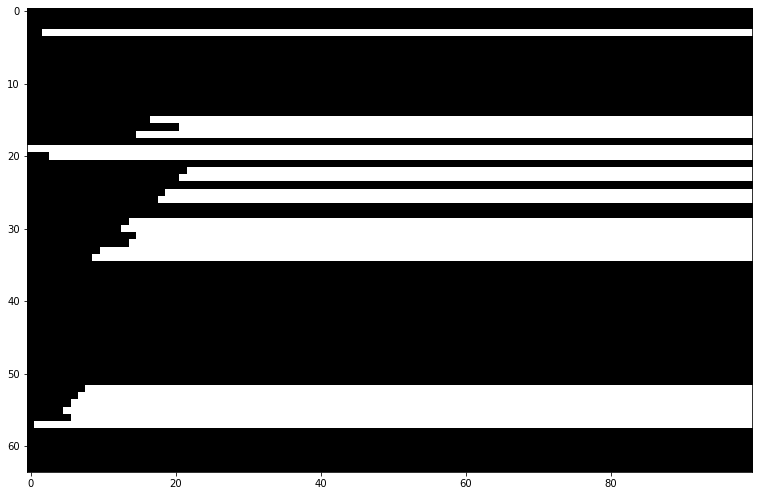

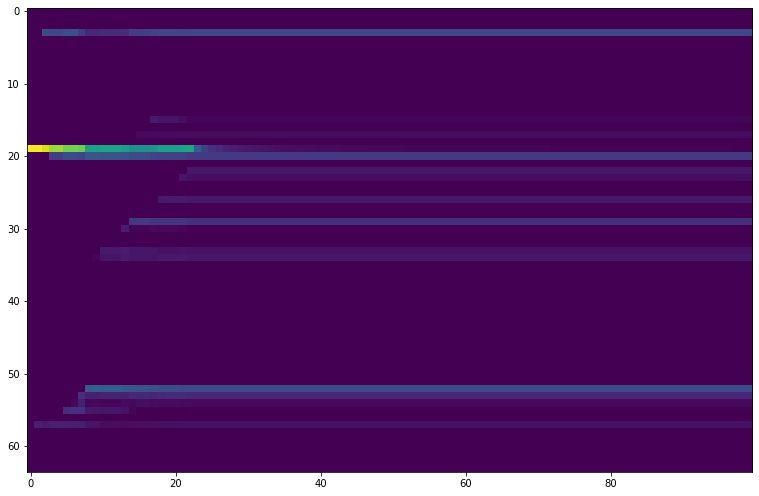

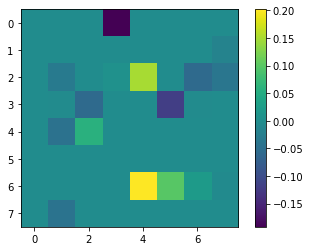

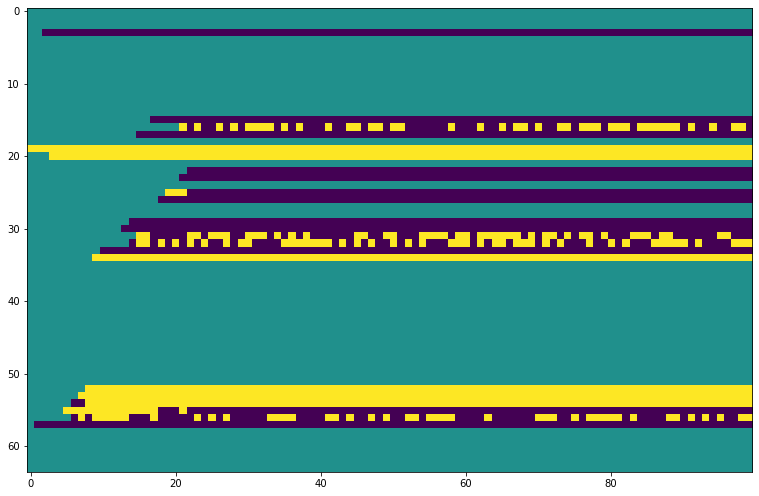

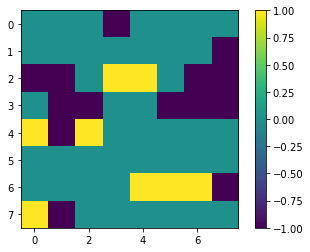

In [35]:
mask = np.logical_or(target==1, target==7)
data_17 = data[mask]
target_17 = target[mask]

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data_17, target_17, test_size=0.4, random_state=0
)
y_train[y_train == 7] = -1
y_test[y_test == 7] = -1


X = x_train.copy()

std_X = np.std(X, axis=0)
std_X[std_X == 0] = 1
X = (X - np.mean(X, axis=0)) / std_X

y = y_train.copy()

T = 100
beta = omp_regression(X, y, T)
print(beta.shape)


for t in range(0, T, T//100):
    beta_t = beta[:,t]
    y_hat = x_test.dot(beta_t)
    classified = y_hat
    classified[classified >= 0] = 1
    classified[classified < 0] = -1
    error_r2 = (y_test-y_hat).dot(y_test-y_hat)/(y_test-np.mean(y_test)).dot((y_test-np.mean(y_test)))
    print(f"t: {t}\t{error_r2}\t{np.mean(classified != y_test)}")

plt.figure(figsize=(13,13))
plt.imshow(np.abs(beta)!=0, cmap="gray")
plt.show()
plt.figure(figsize=(13,13))
plt.imshow(np.abs(beta))
plt.show()


beta_T = beta[:,-1].reshape(8,8)
plt.imshow(beta_T)
plt.colorbar()
plt.show()

beta[beta > 0] = 1
beta[beta < 0] = -1
plt.figure(figsize=(13,13))
plt.imshow(beta)
plt.show()

beta_T = beta[:,-1].reshape(8,8)
plt.imshow(beta_T)
plt.colorbar()
plt.show()

### 4.3 One-against-the-rest classification

total error: 0.612
confusion matrix
(percentages in a column sum up to 100%)


true,unknown,0,1,2,3,4,5,6,7,8,9
predicted,,,,,,,,,,,
unknown,0.00%,16.67%,32.88%,88.73%,72.86%,47.62%,13.48%,19.74%,35.38%,66.67%,60.81%
0,0.00%,83.33%,0.00%,0.00%,4.29%,26.98%,3.37%,1.32%,32.31%,0.00%,32.43%
1,0.00%,0.00%,57.53%,4.23%,0.00%,20.63%,0.00%,0.00%,3.08%,6.41%,1.35%
2,0.00%,0.00%,5.48%,1.41%,0.00%,1.59%,0.00%,0.00%,0.00%,0.00%,0.00%
3,0.00%,0.00%,0.00%,2.82%,22.86%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,0.00%,1.59%,0.00%,0.00%,0.00%,0.00%,0.00%
5,0.00%,0.00%,1.37%,0.00%,0.00%,0.00%,82.02%,0.00%,0.00%,2.56%,5.41%
6,0.00%,0.00%,1.37%,0.00%,0.00%,0.00%,1.12%,78.95%,1.54%,1.28%,0.00%
7,0.00%,0.00%,0.00%,0.00%,0.00%,1.59%,0.00%,0.00%,27.69%,0.00%,0.00%


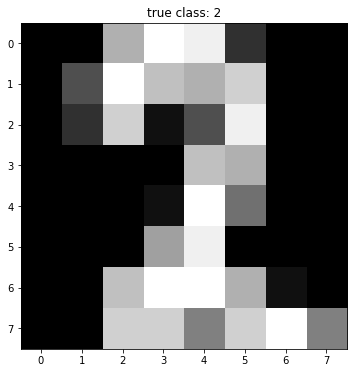

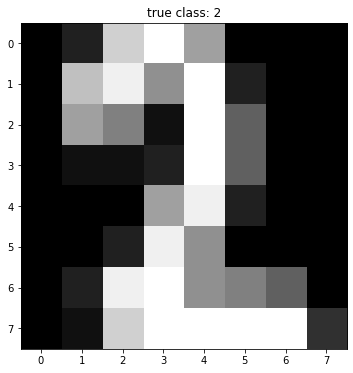

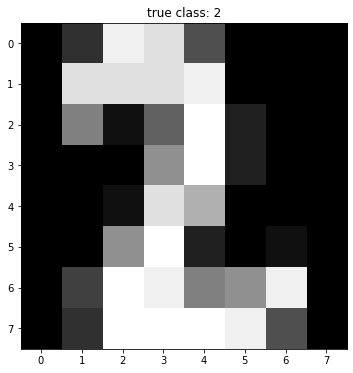

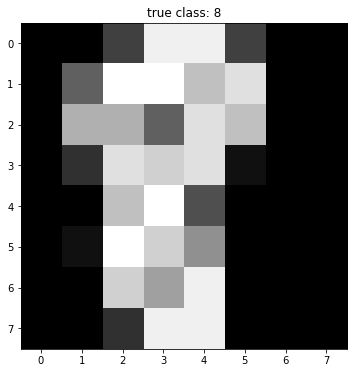

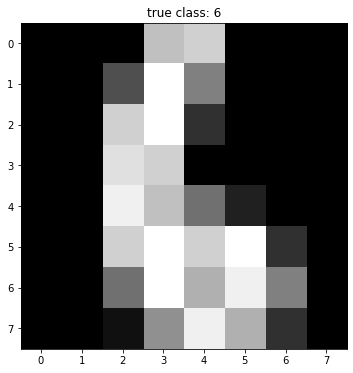

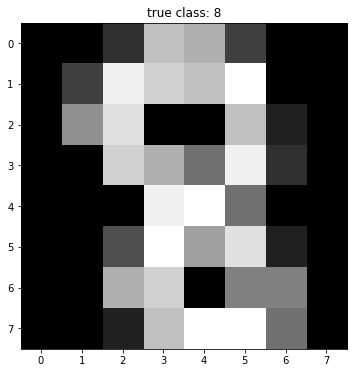

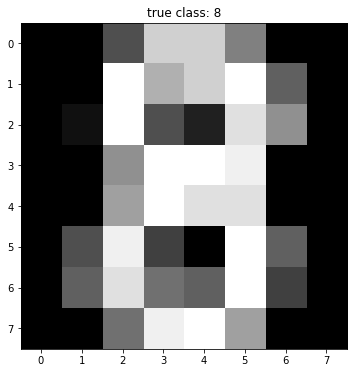

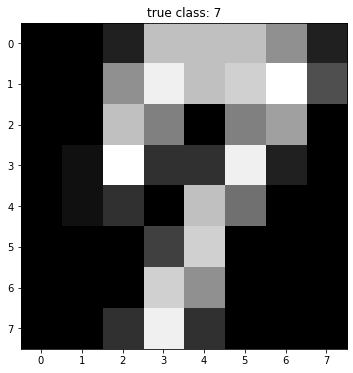

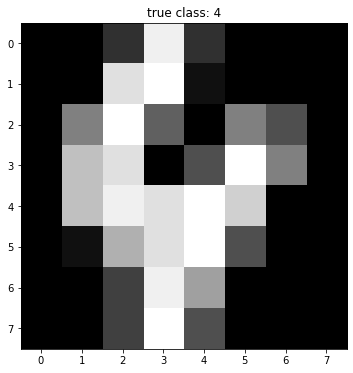

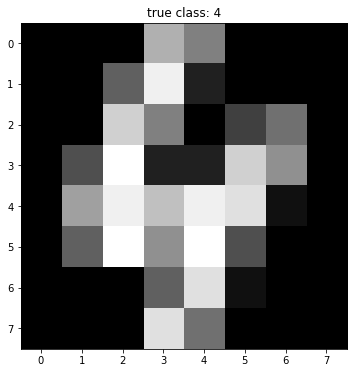

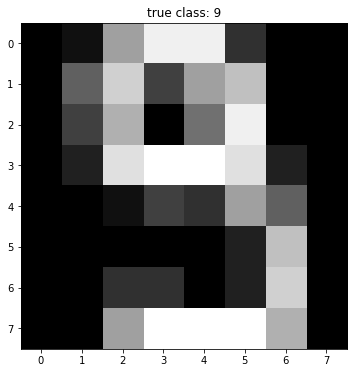

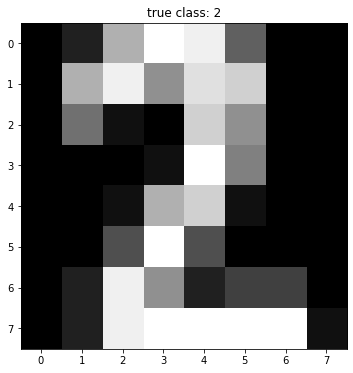

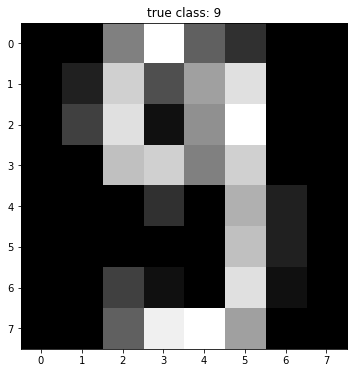

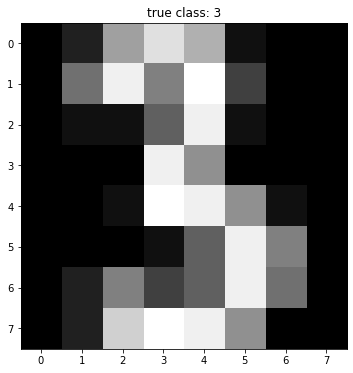

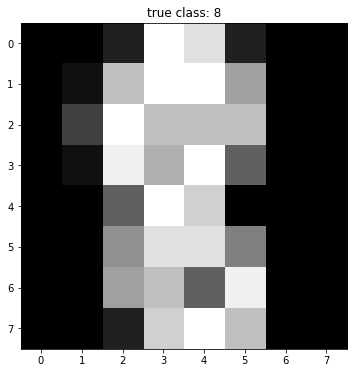

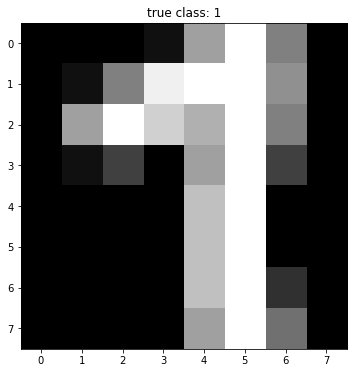

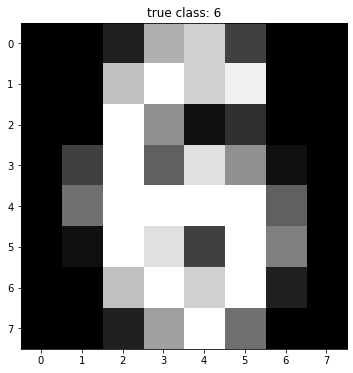

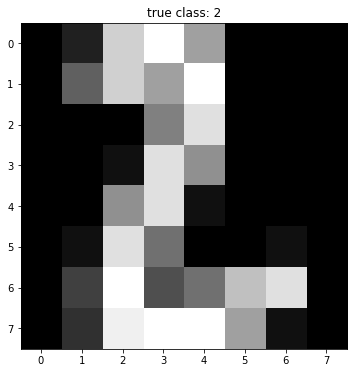

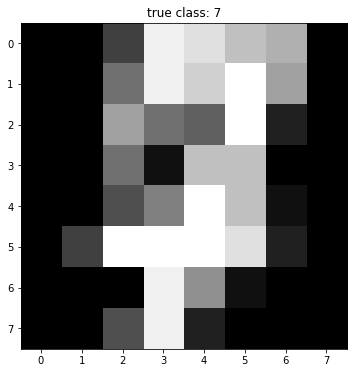

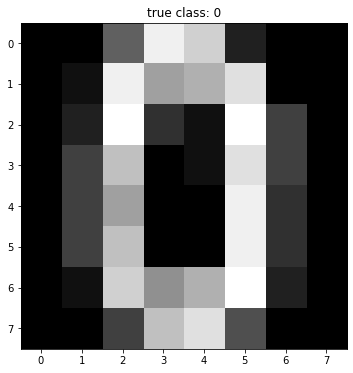

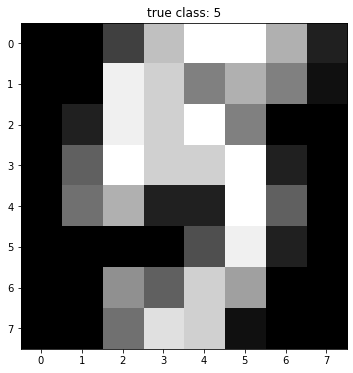

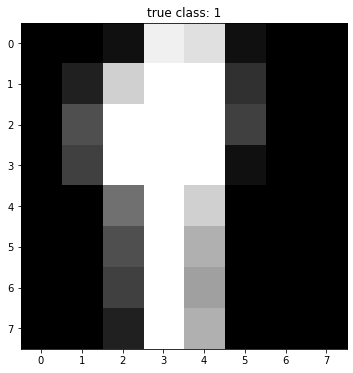

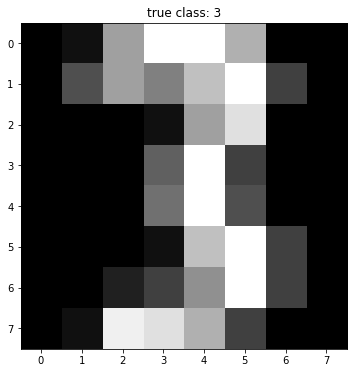

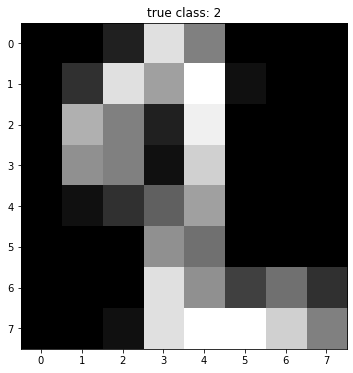

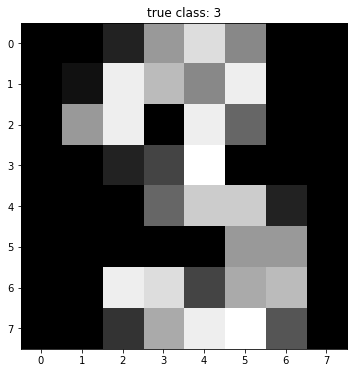

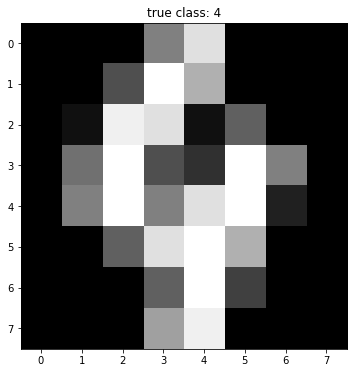

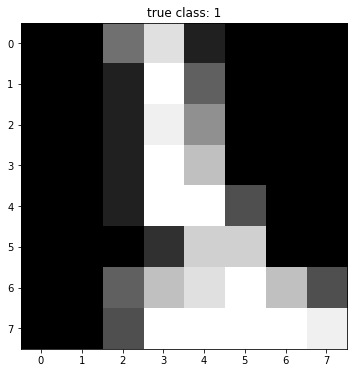

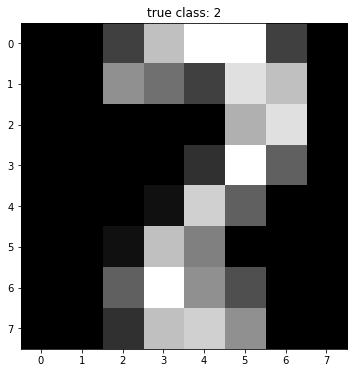

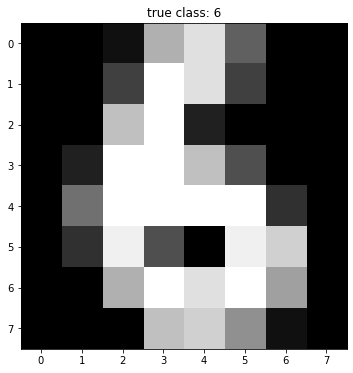

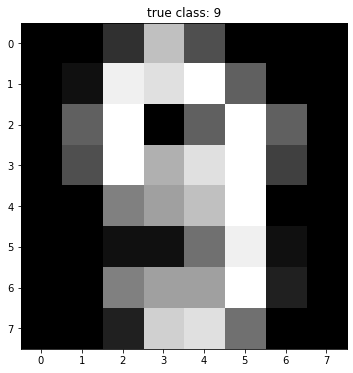

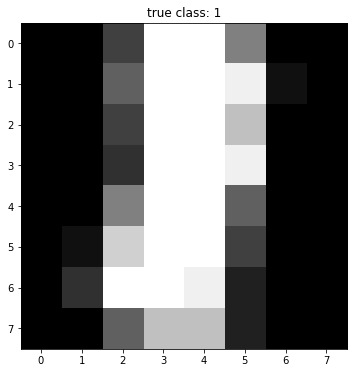

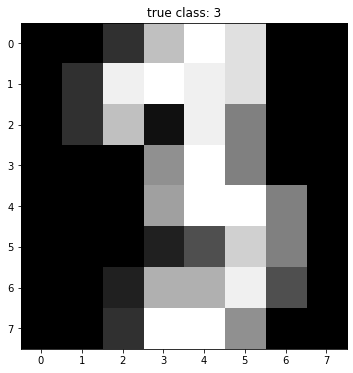

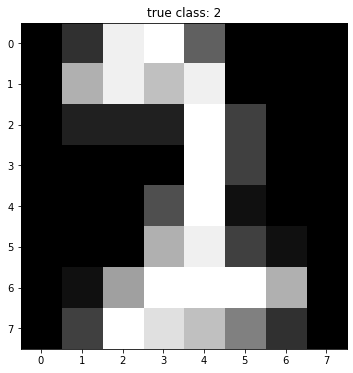

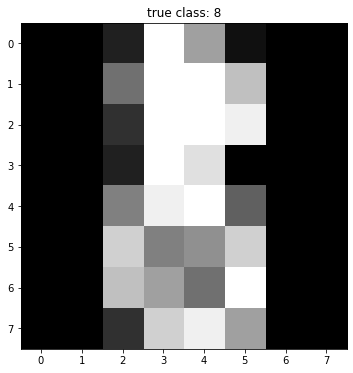

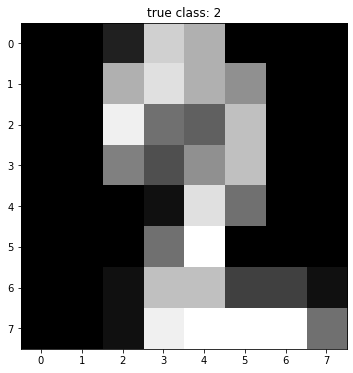

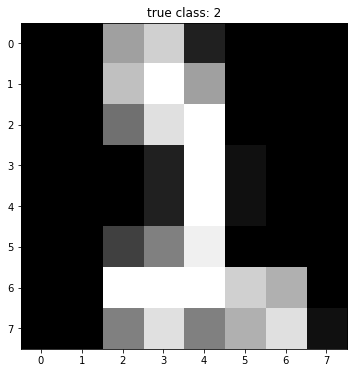

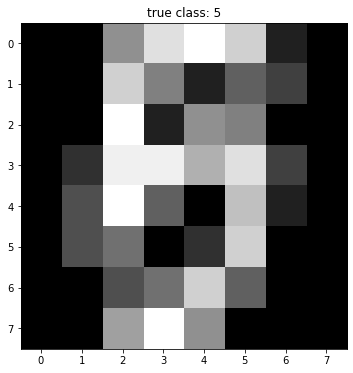

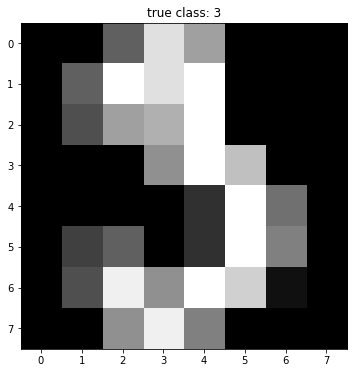

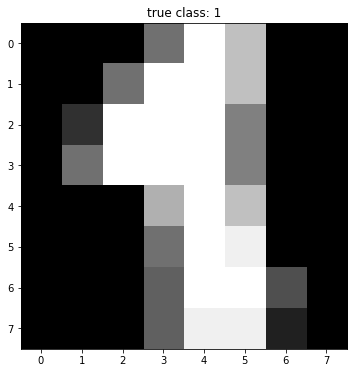

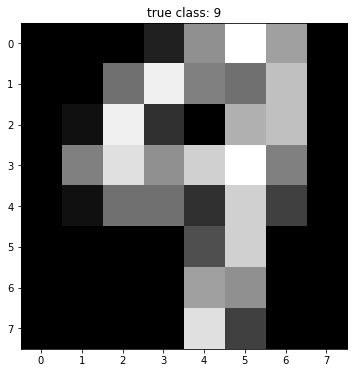

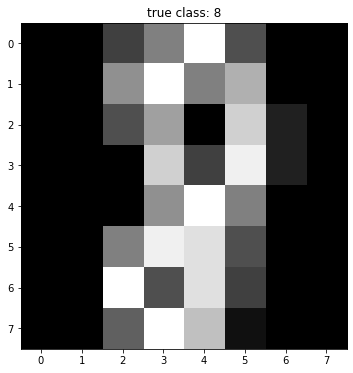

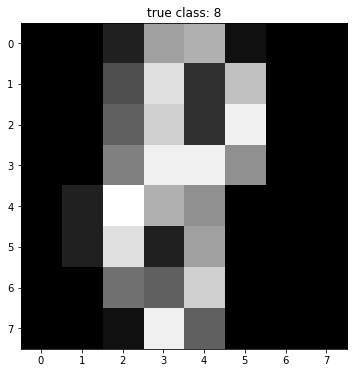

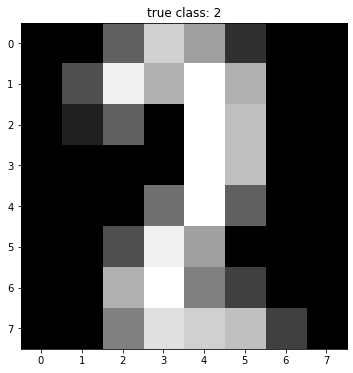

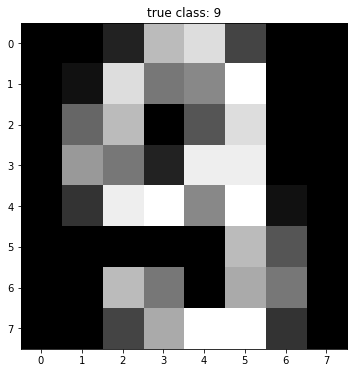

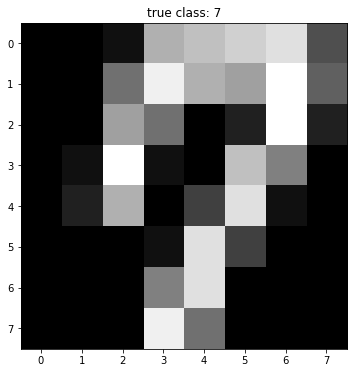

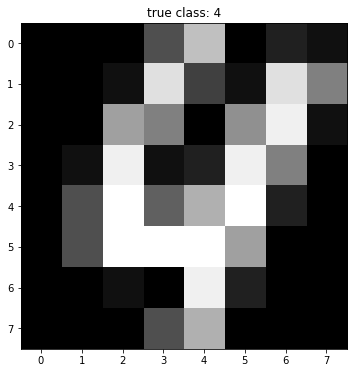

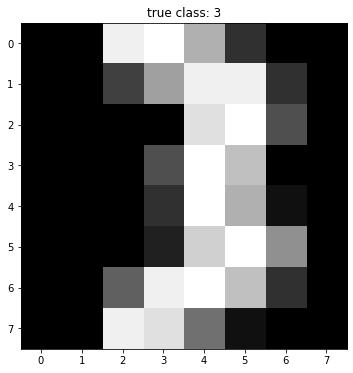

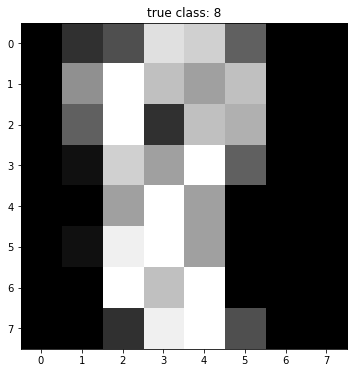

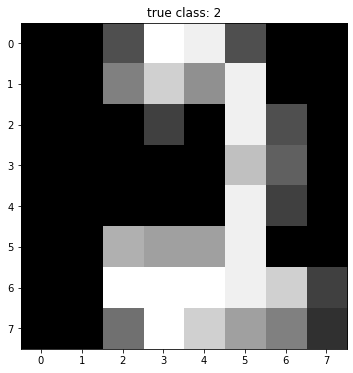

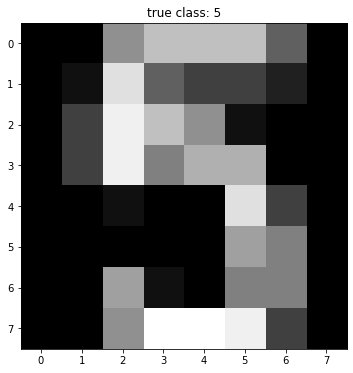

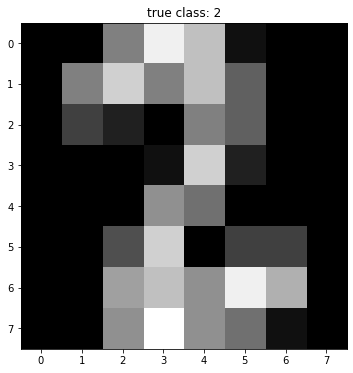

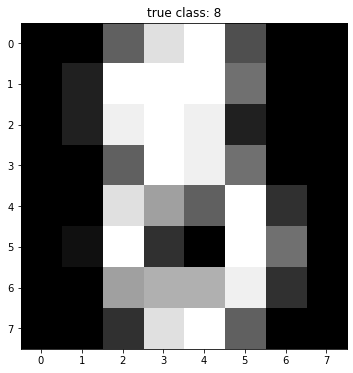

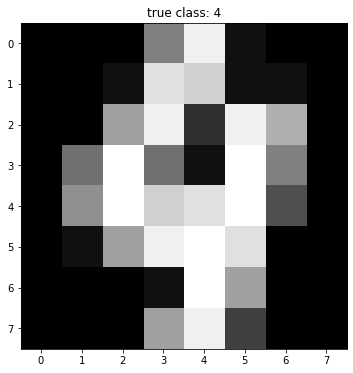

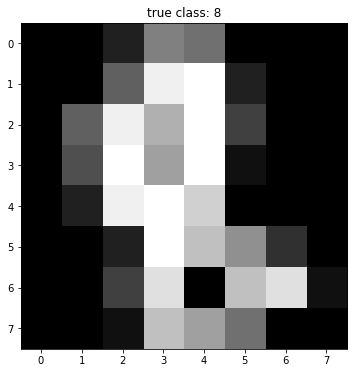

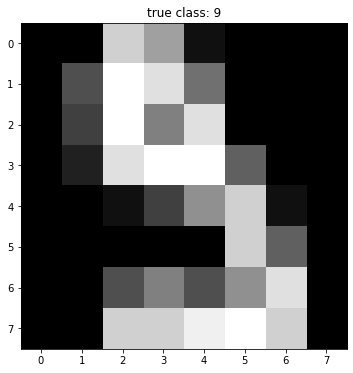

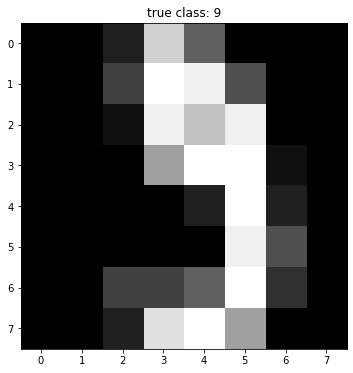

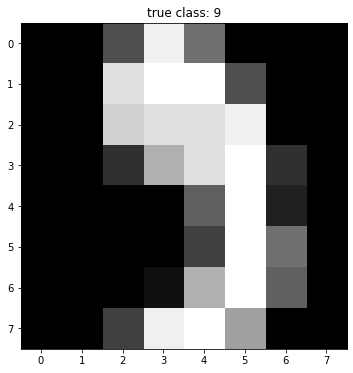

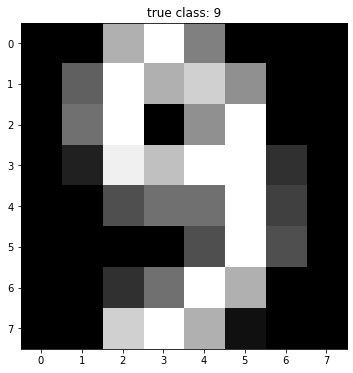

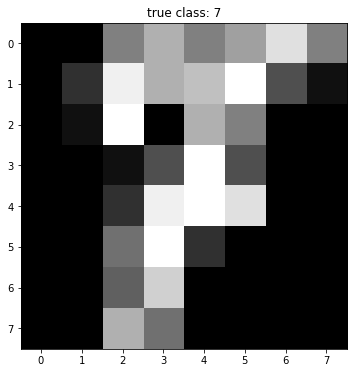

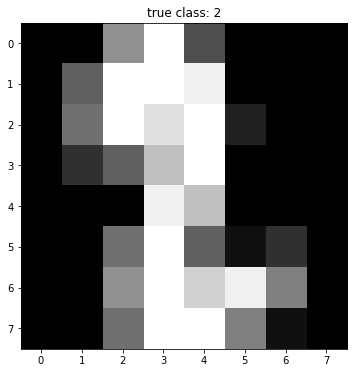

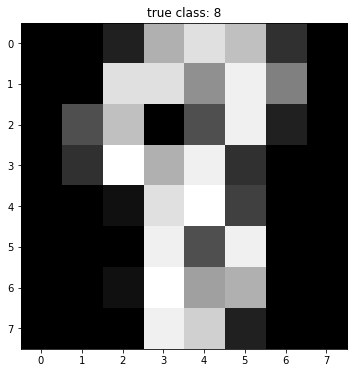

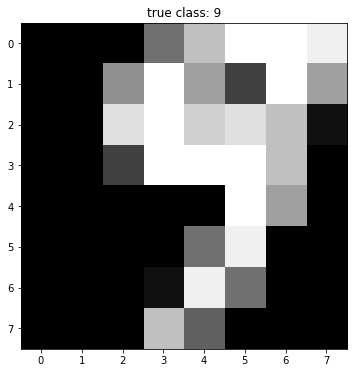

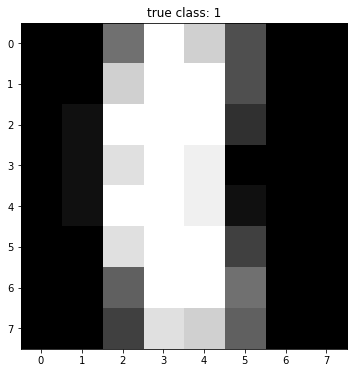

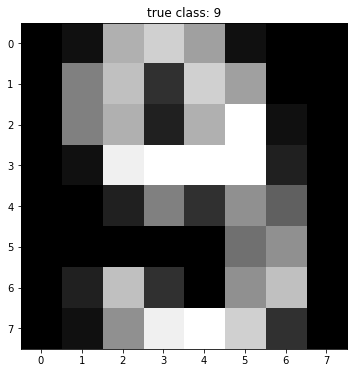

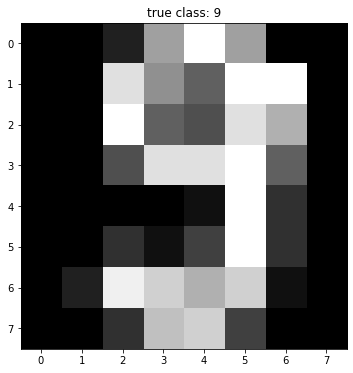

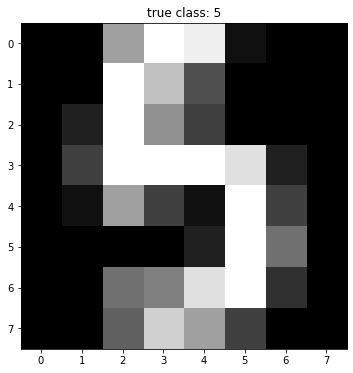

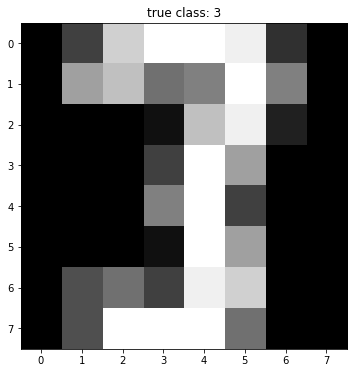

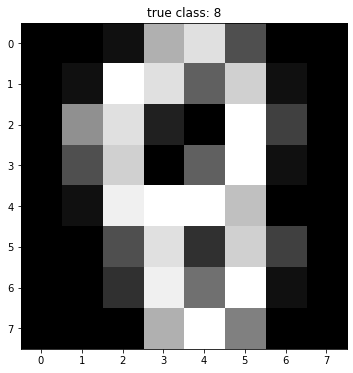

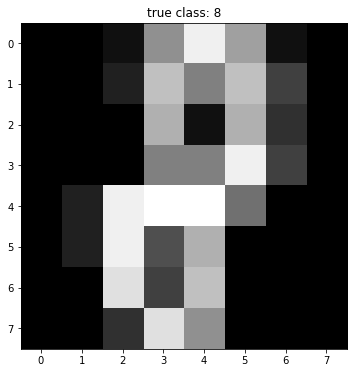

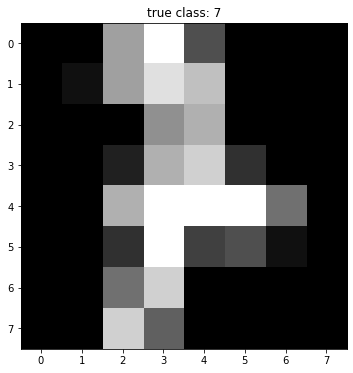

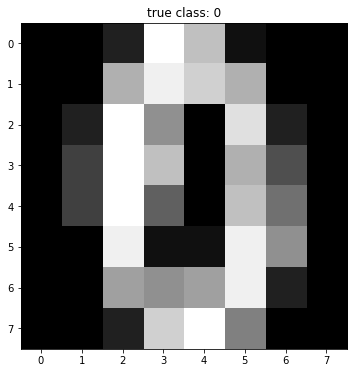

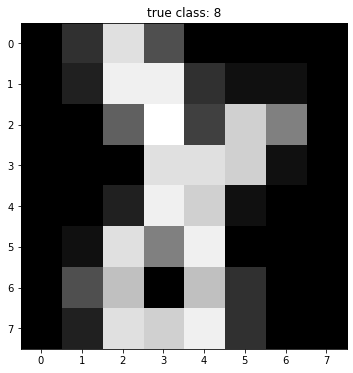

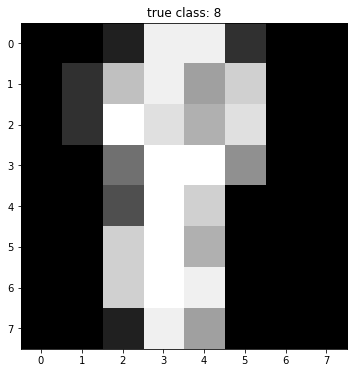

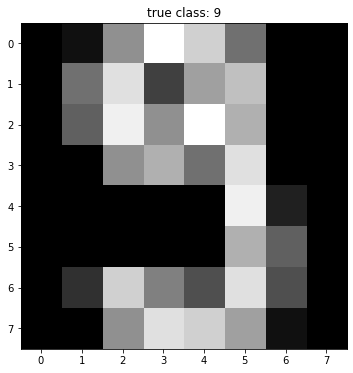

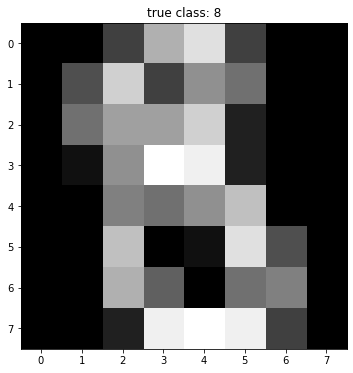

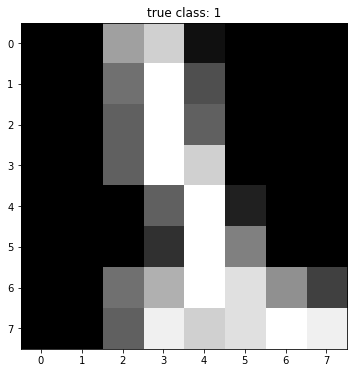

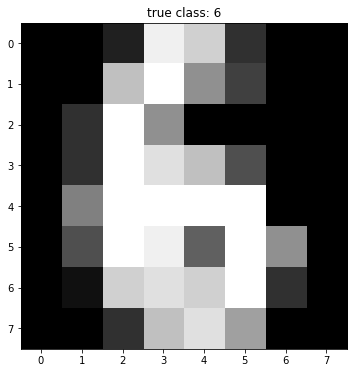

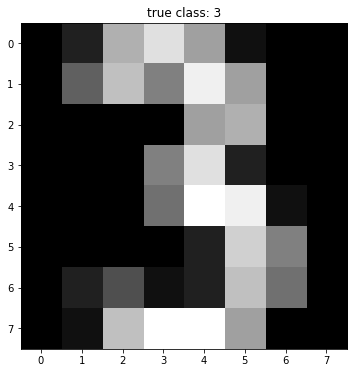

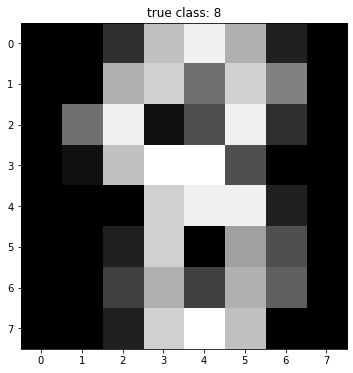

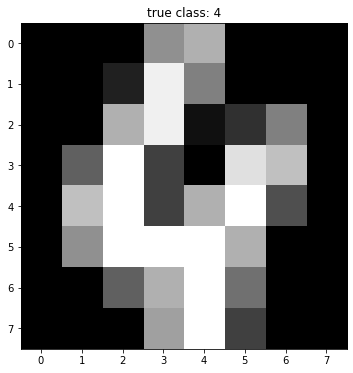

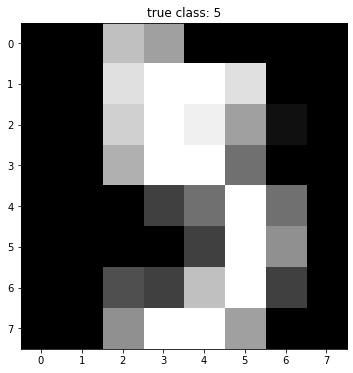

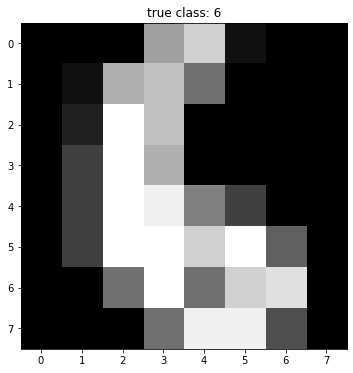

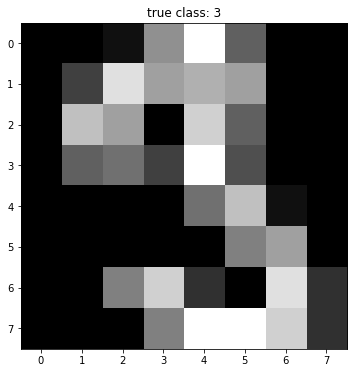

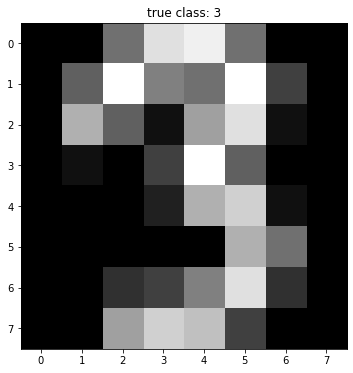

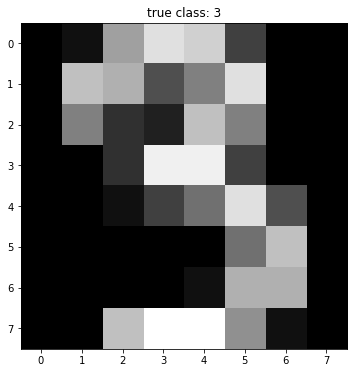

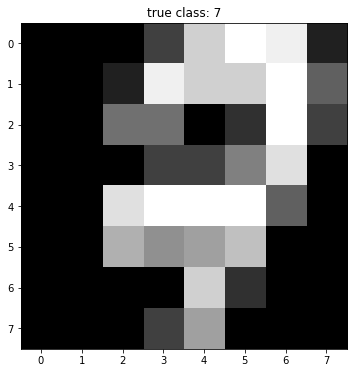

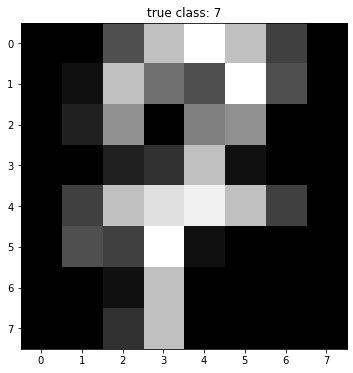

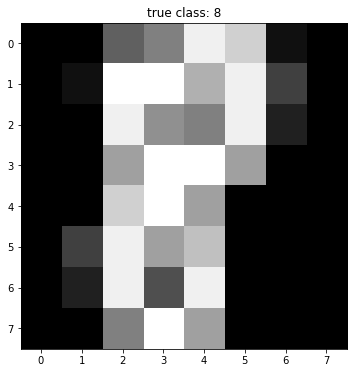

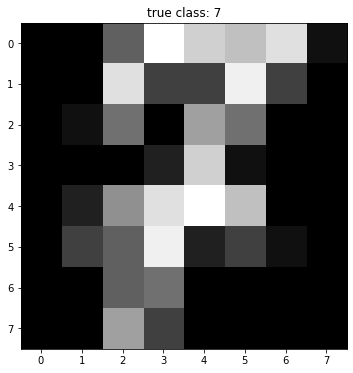

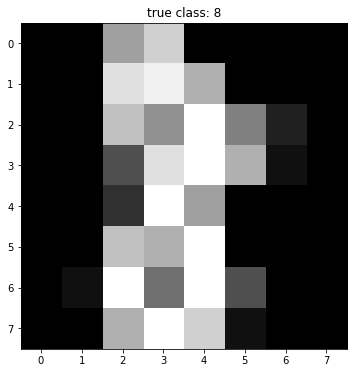

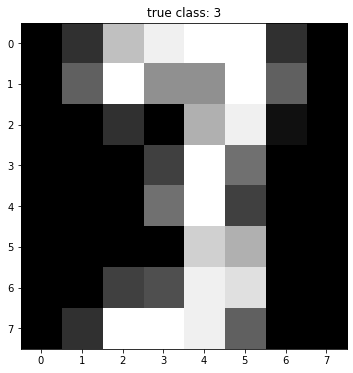

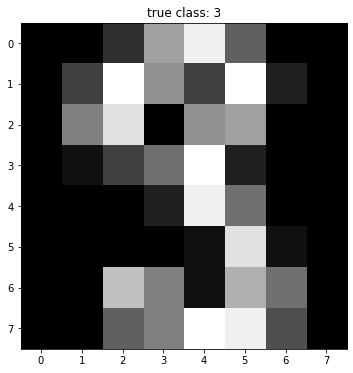

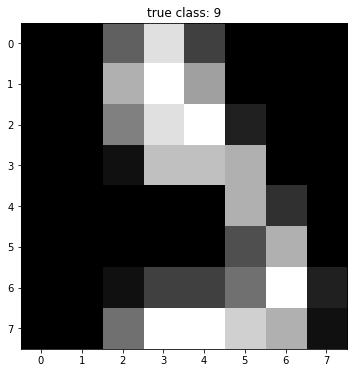

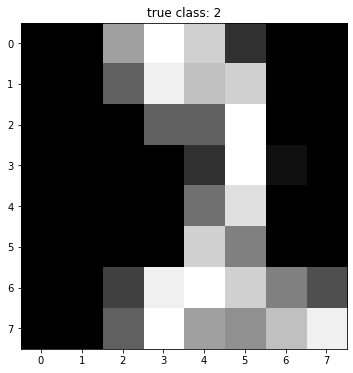

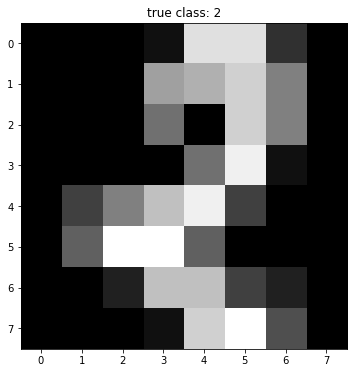

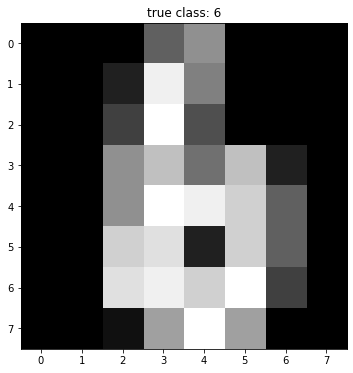

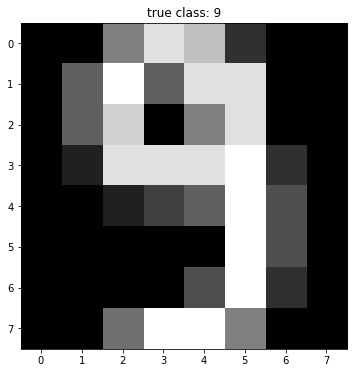

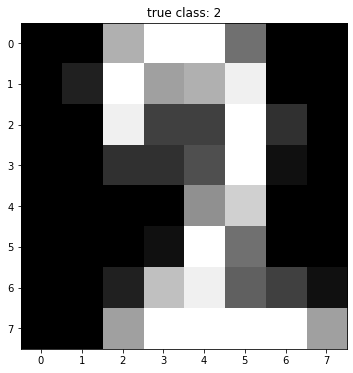

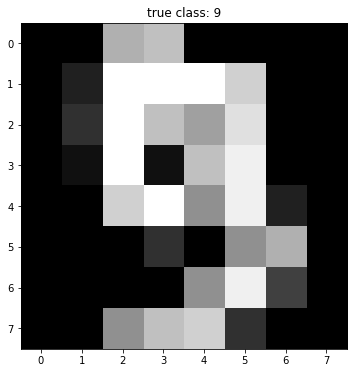

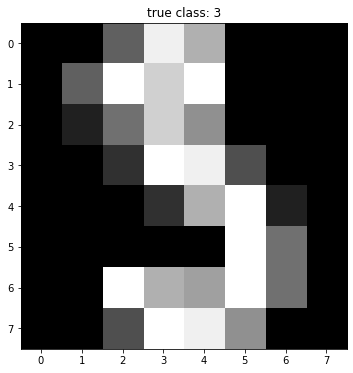

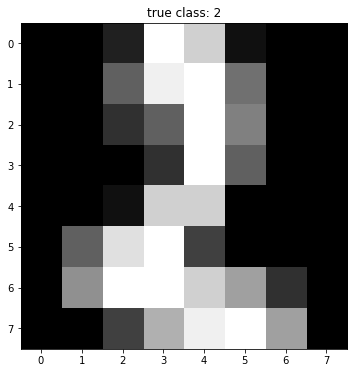

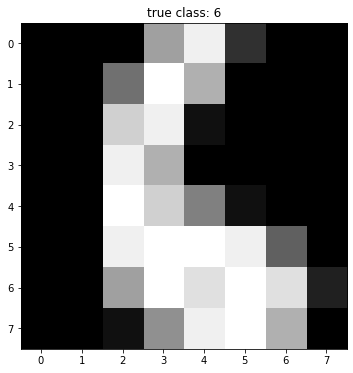

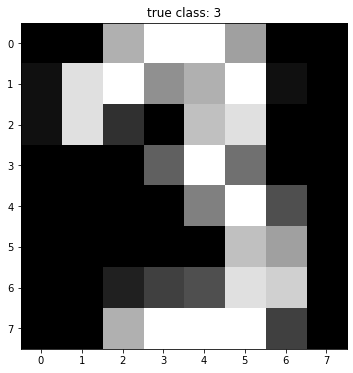

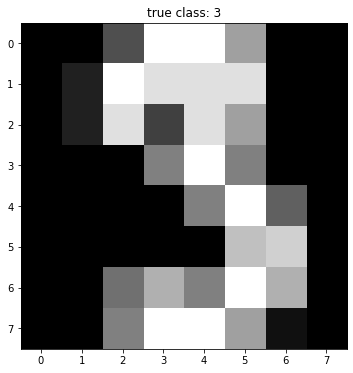

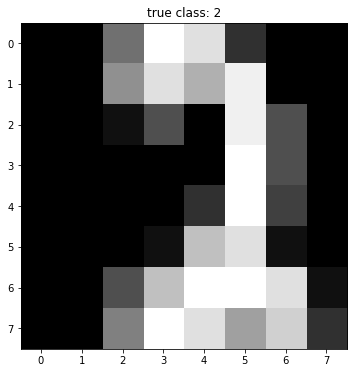

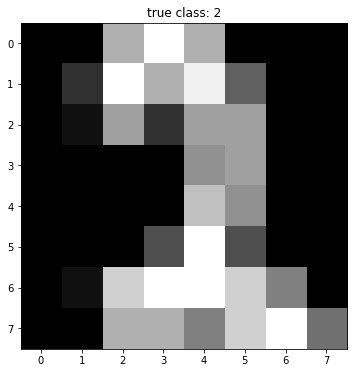

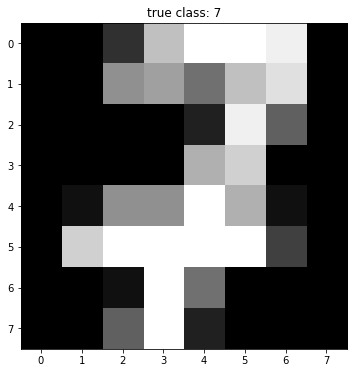

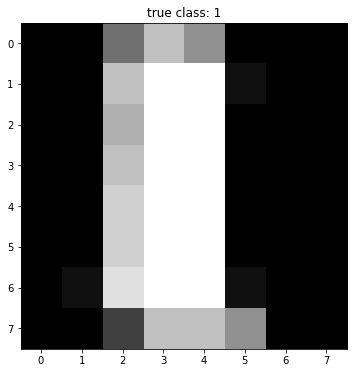

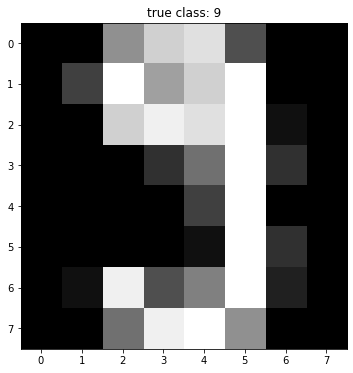

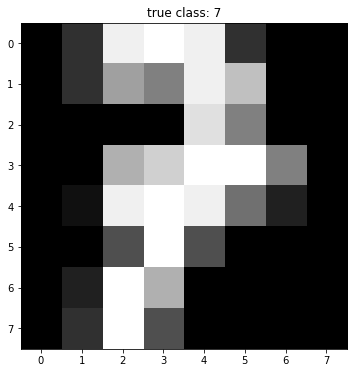

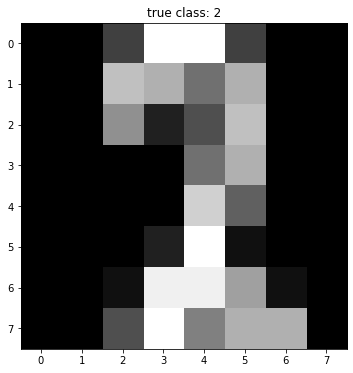

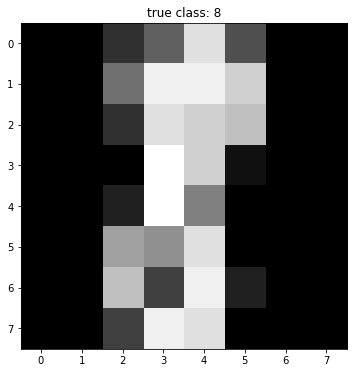

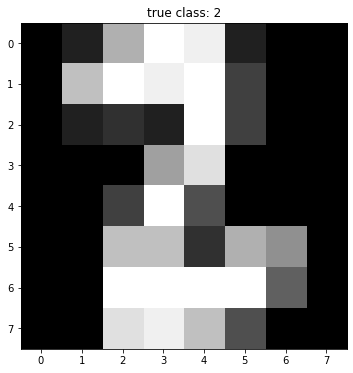

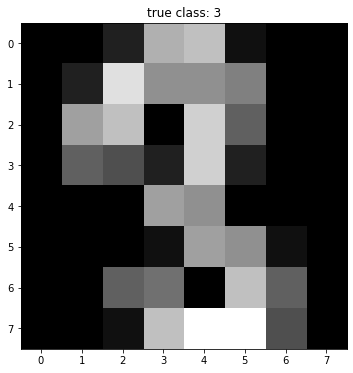

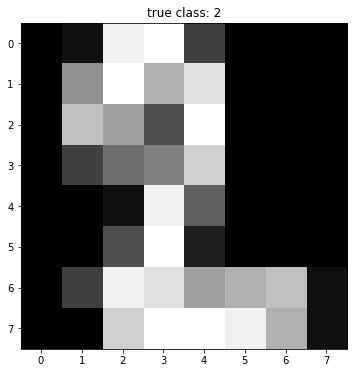

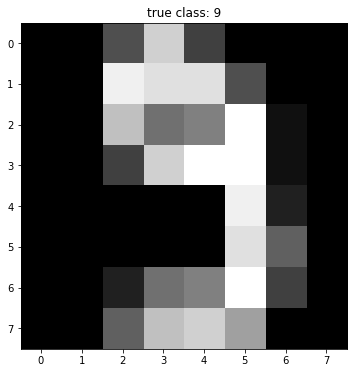

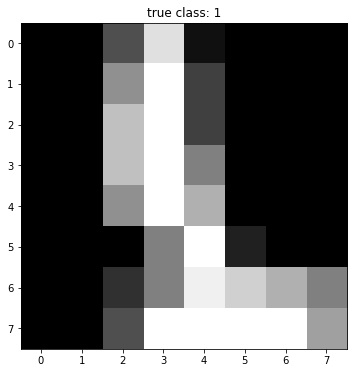

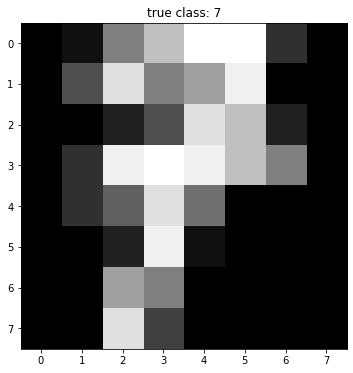

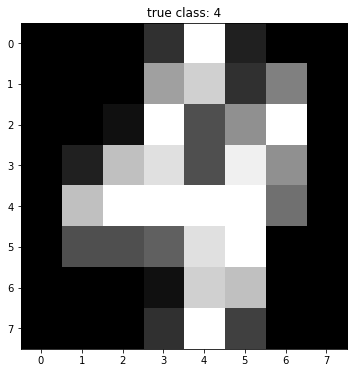

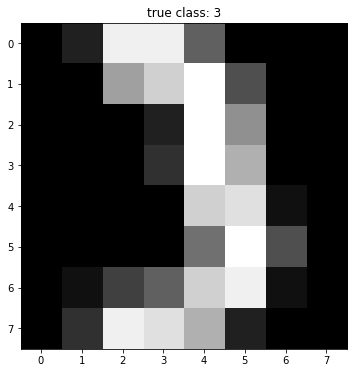

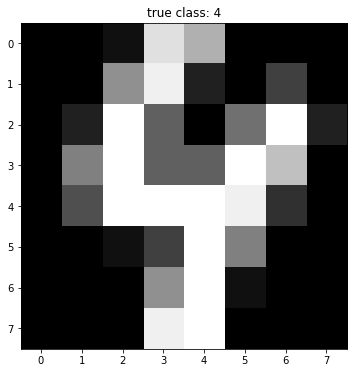

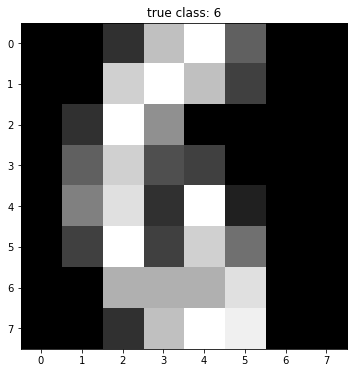

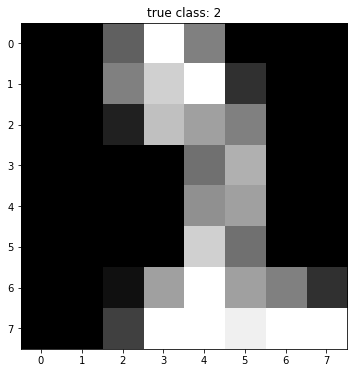

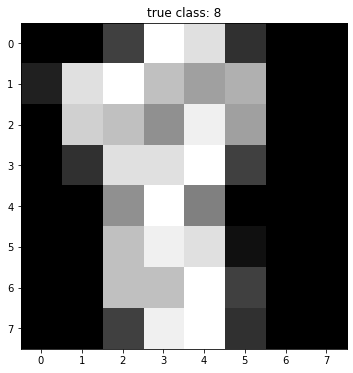

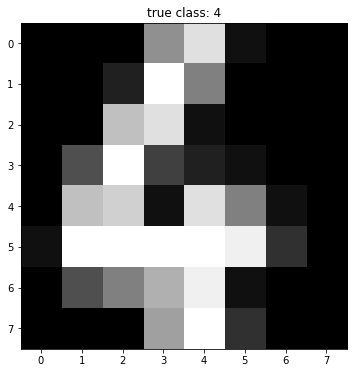

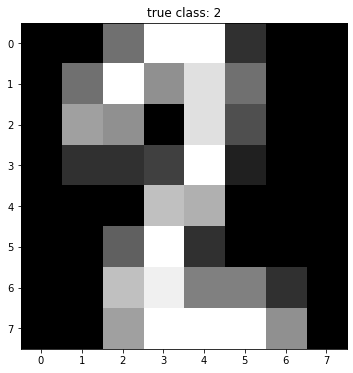

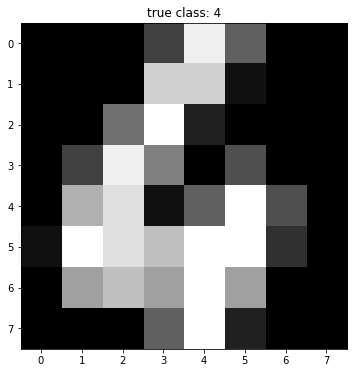

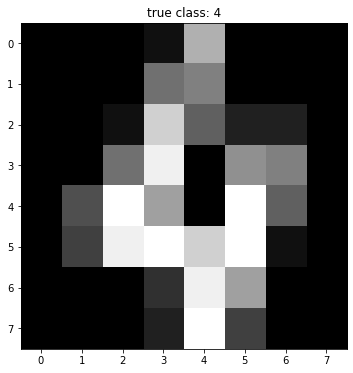

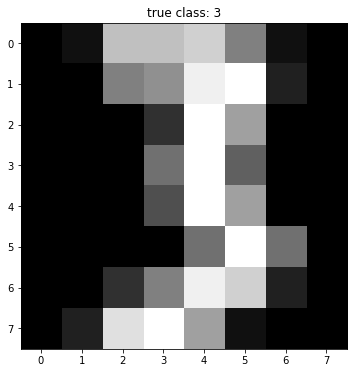

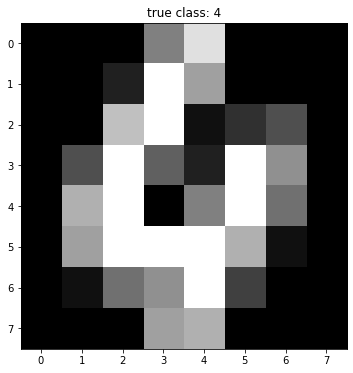

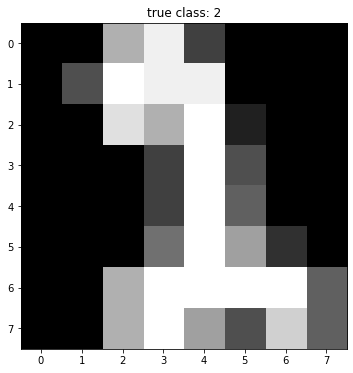

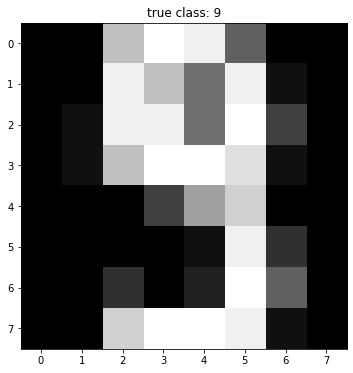

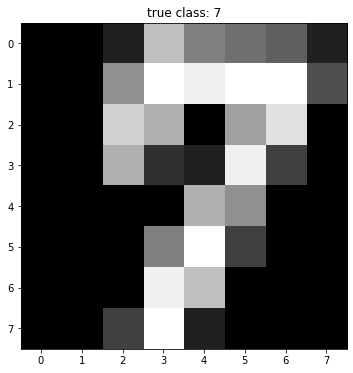

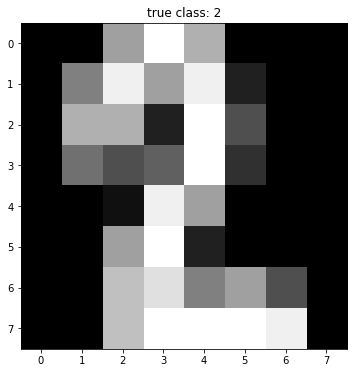

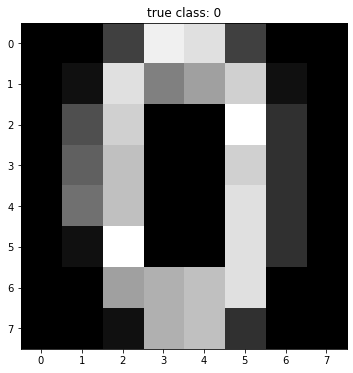

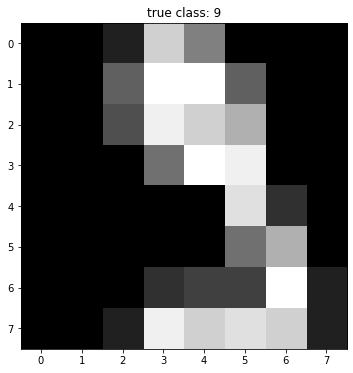

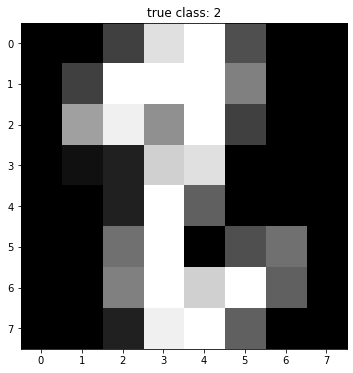

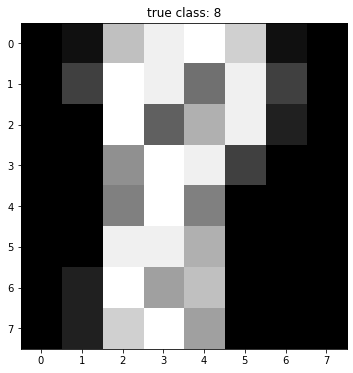

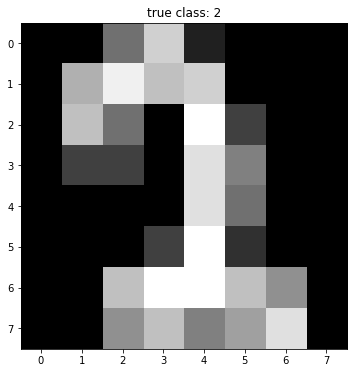

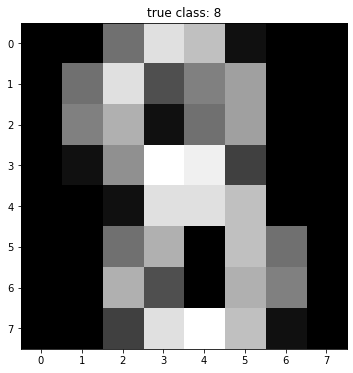

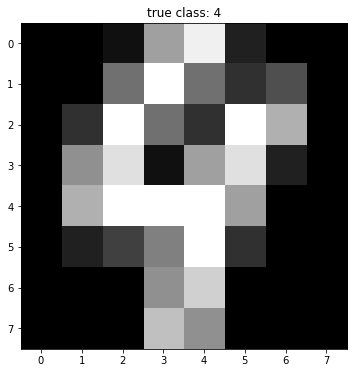

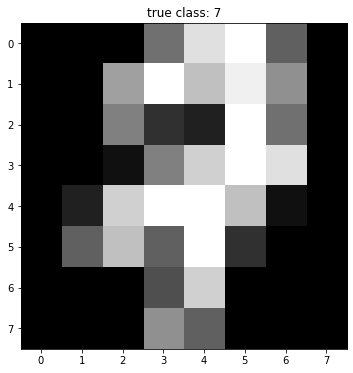

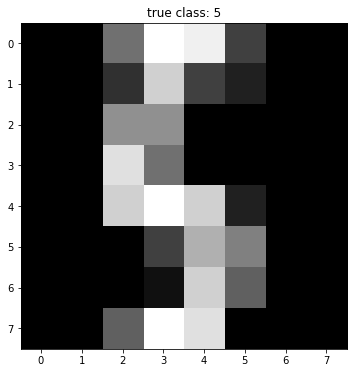

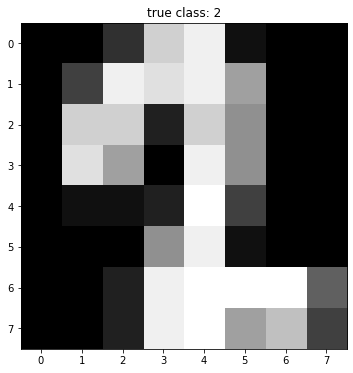

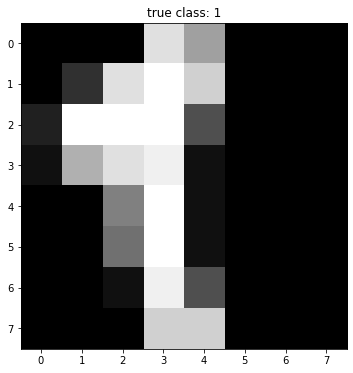

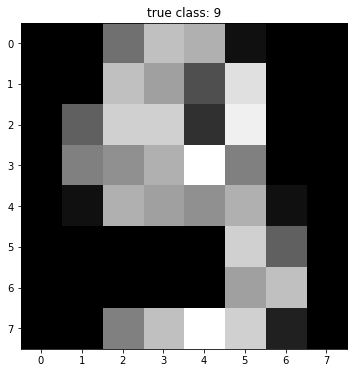

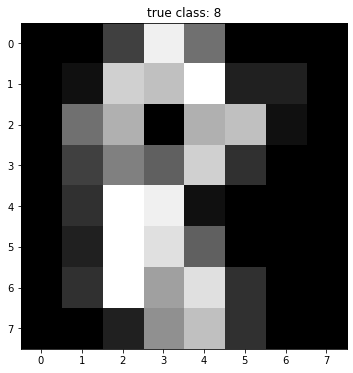

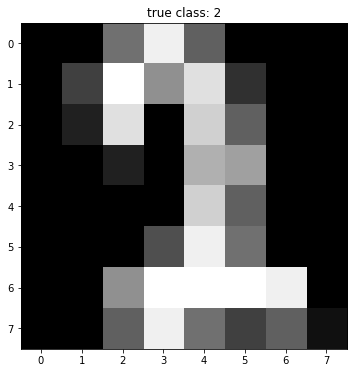

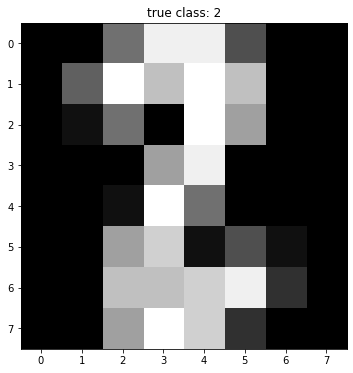

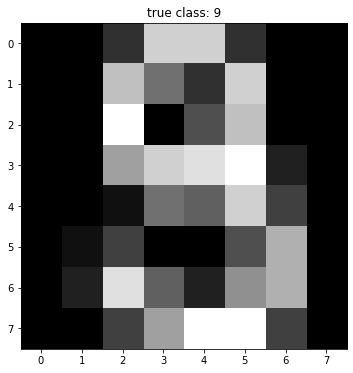

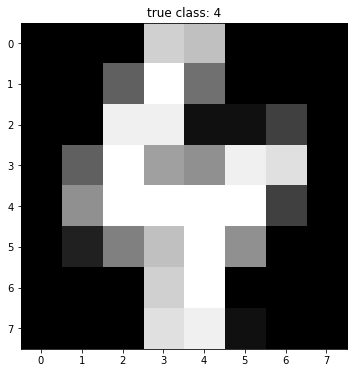

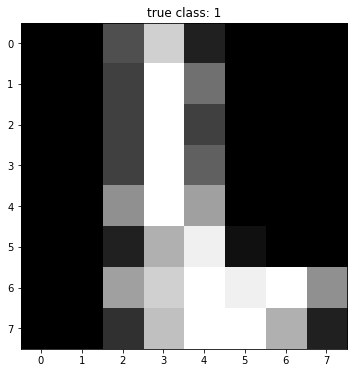

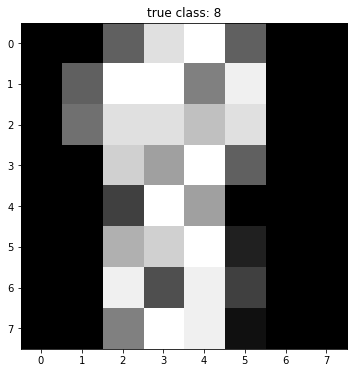

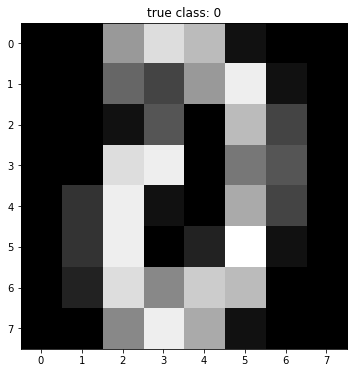

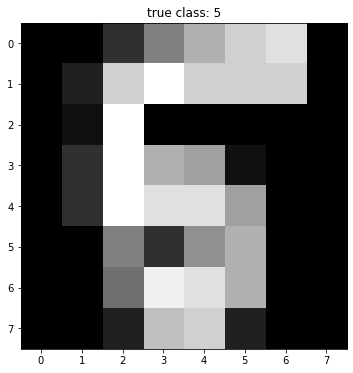

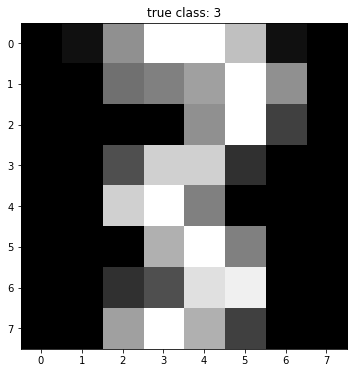

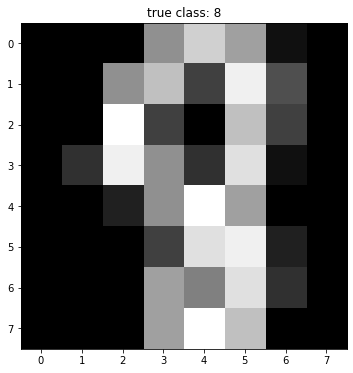

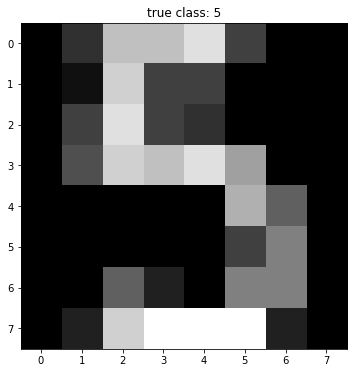

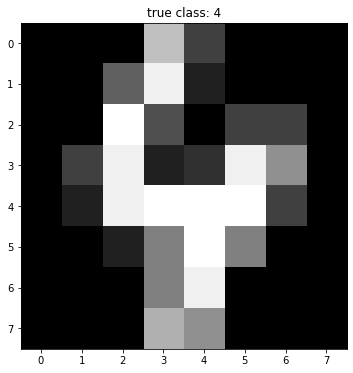

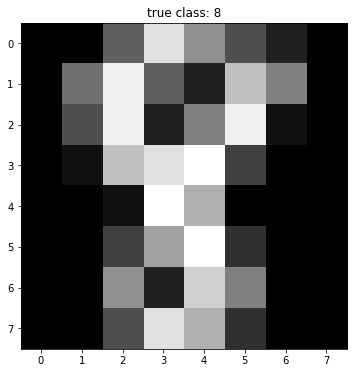

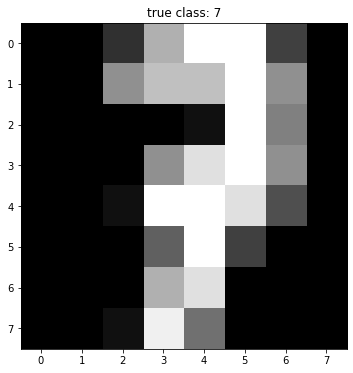

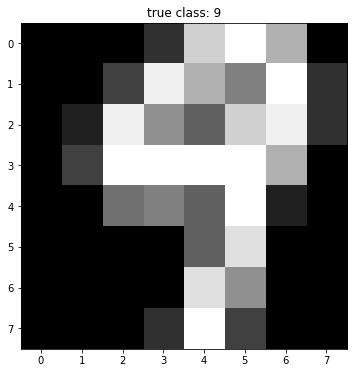

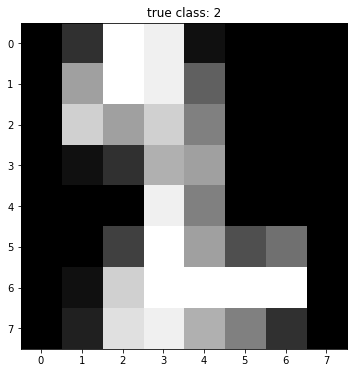

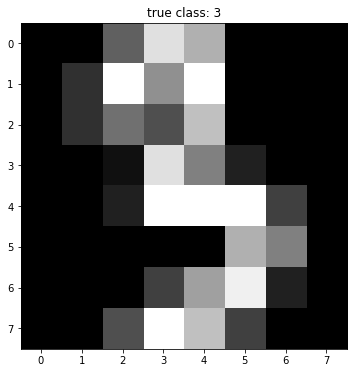

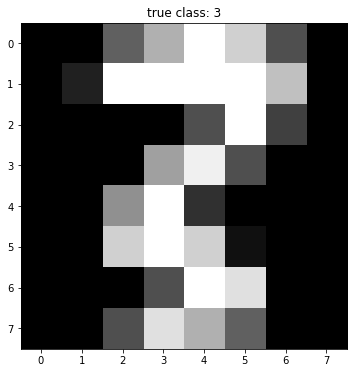

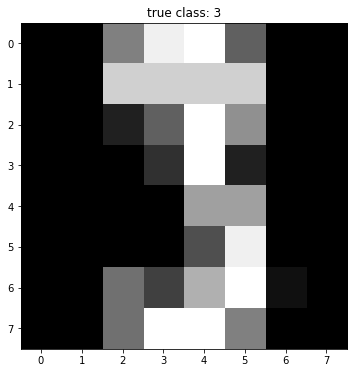

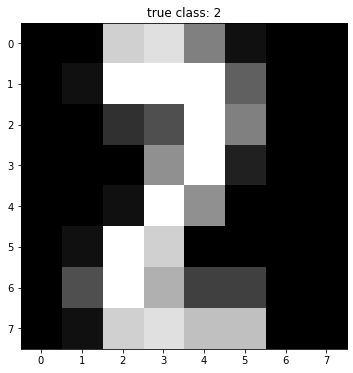

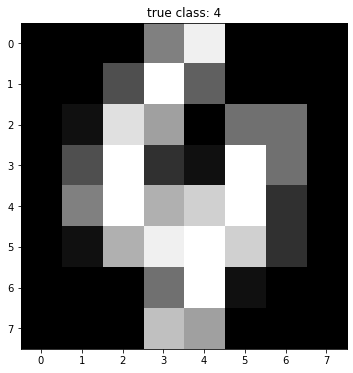

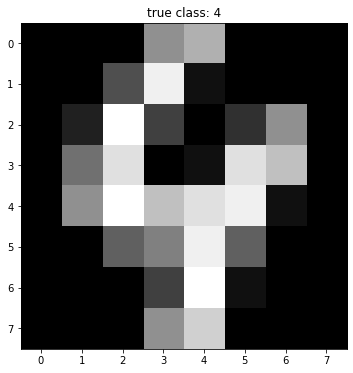

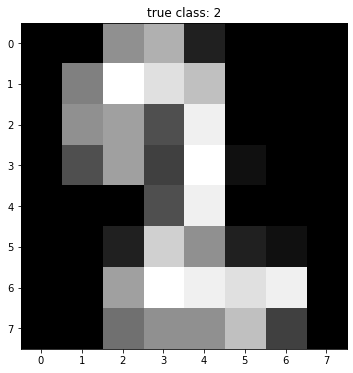

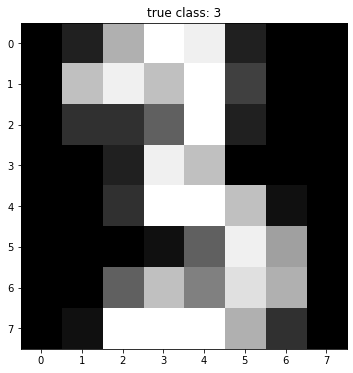

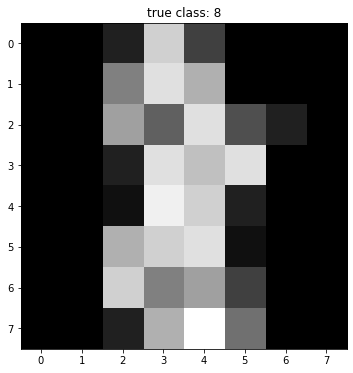

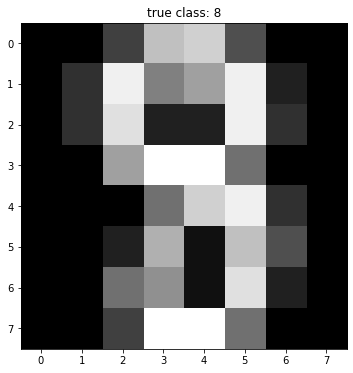

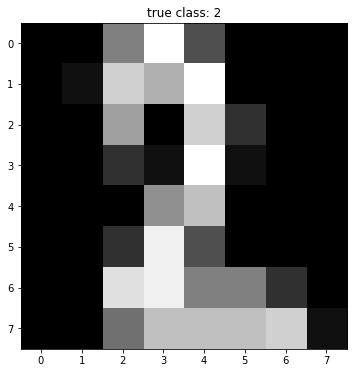

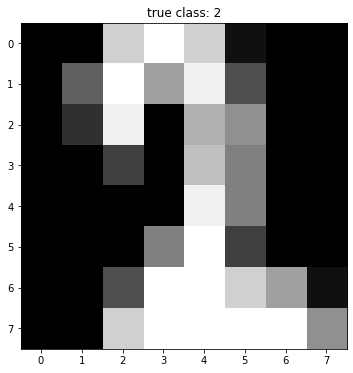

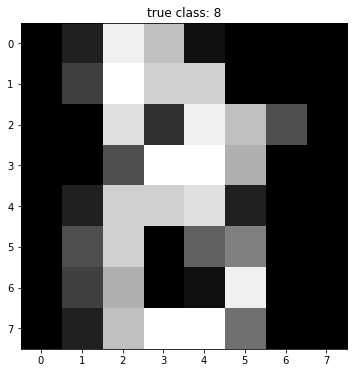

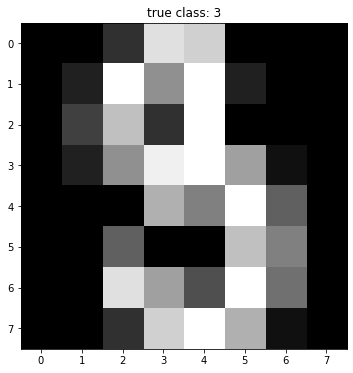

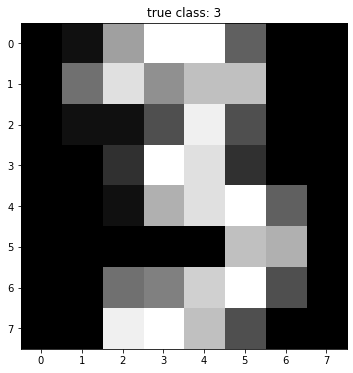

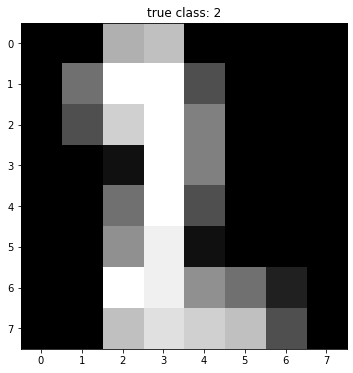

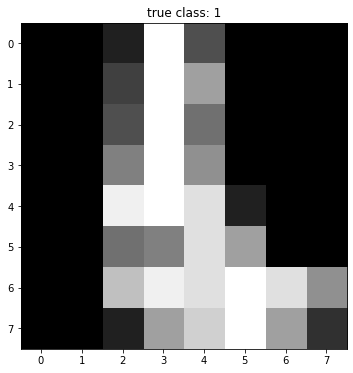

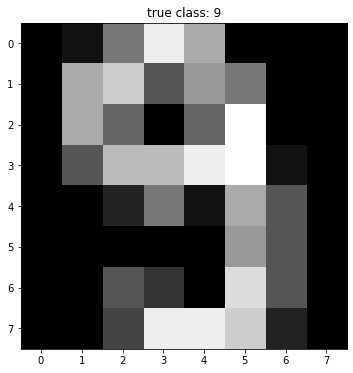

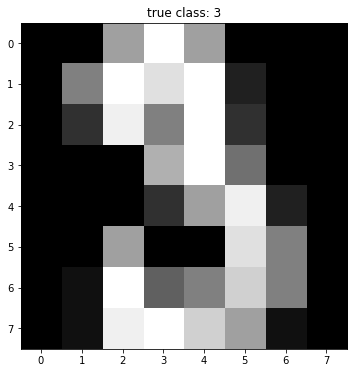

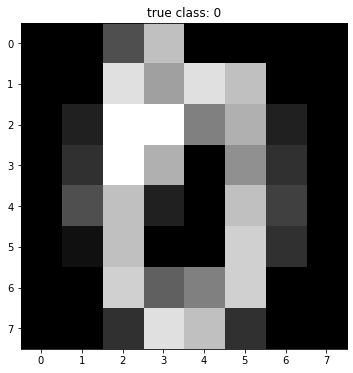

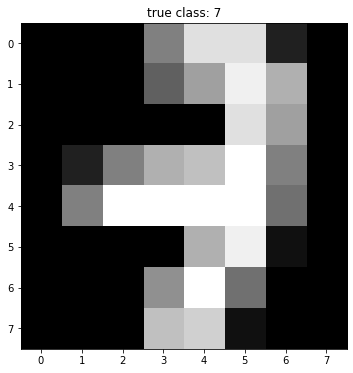

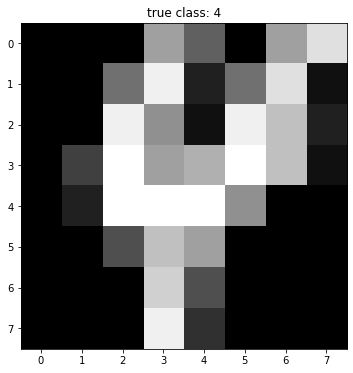

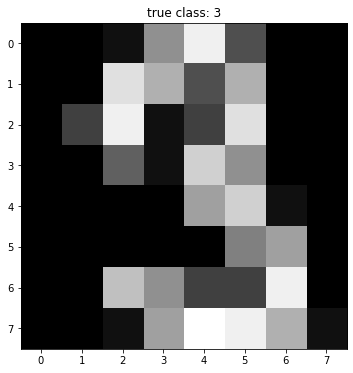

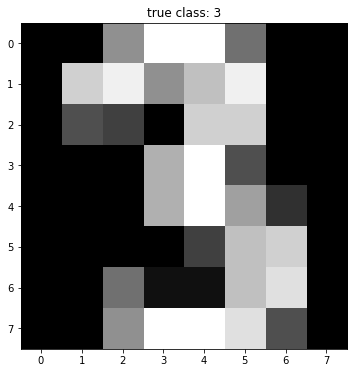

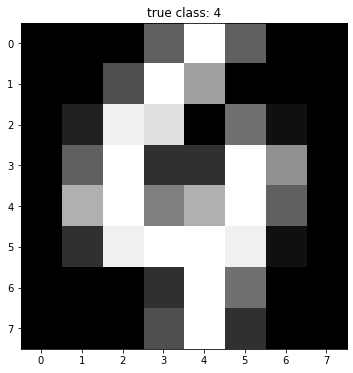

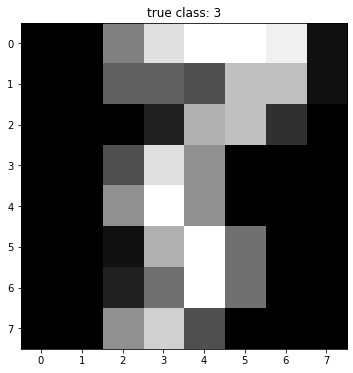

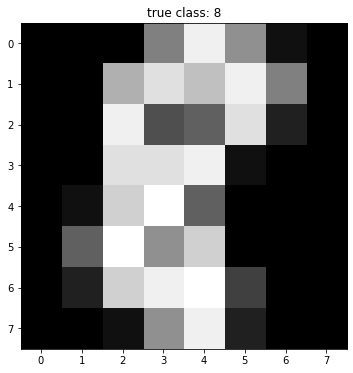

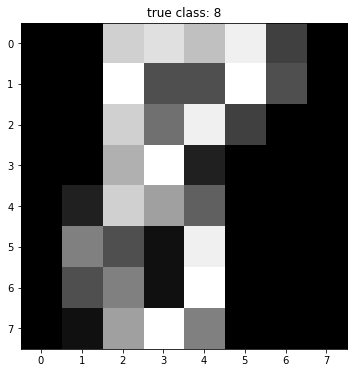

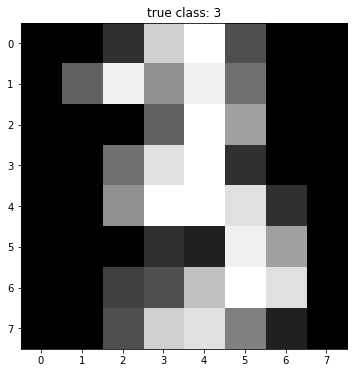

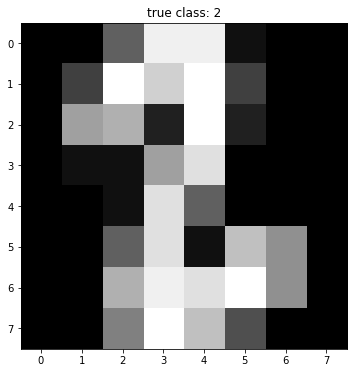

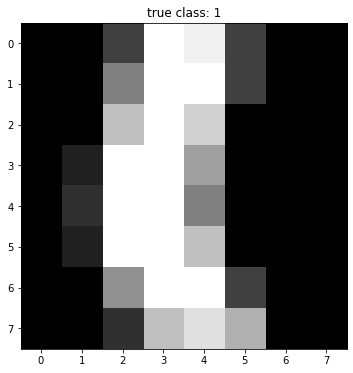

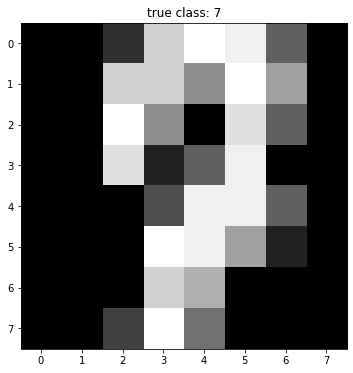

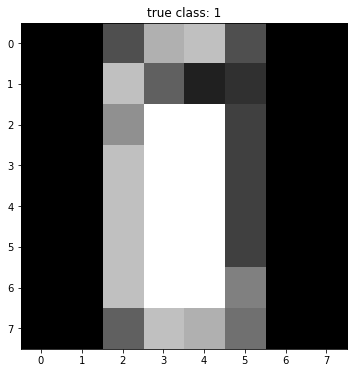

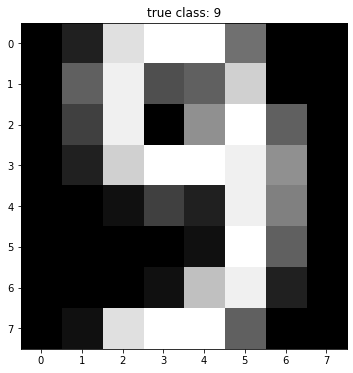

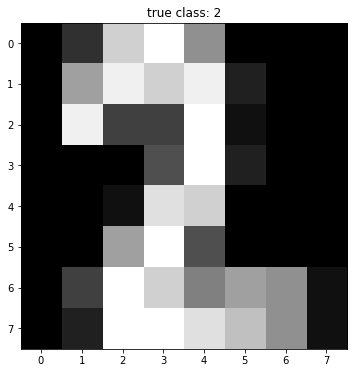

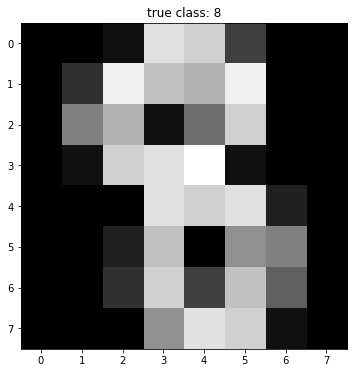

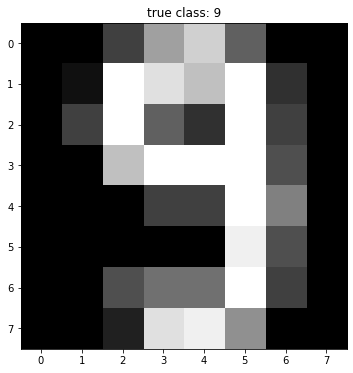

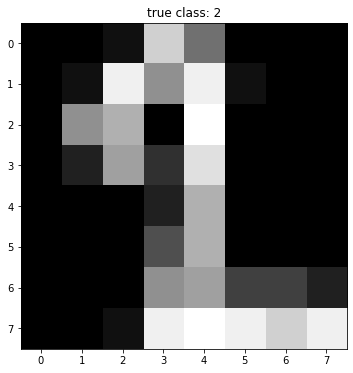

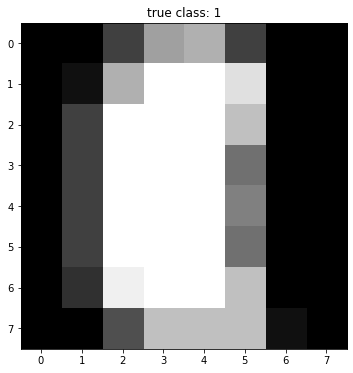

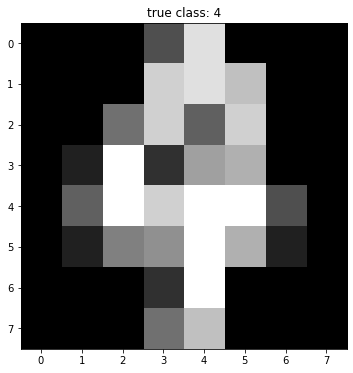

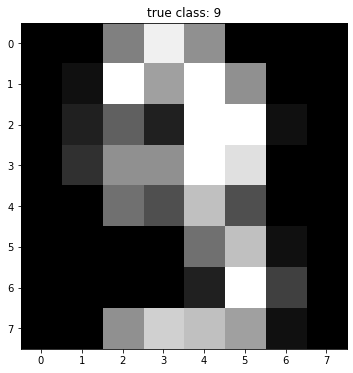

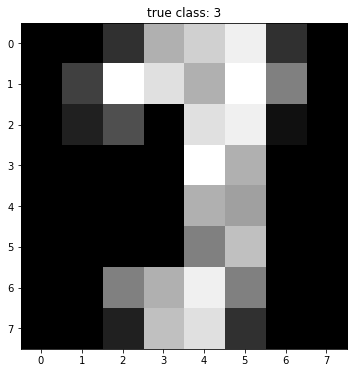

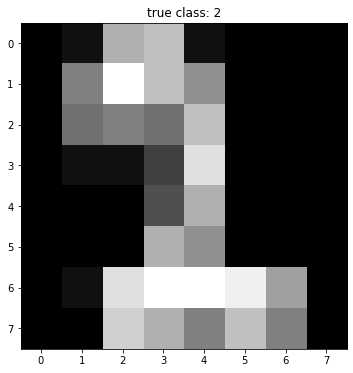

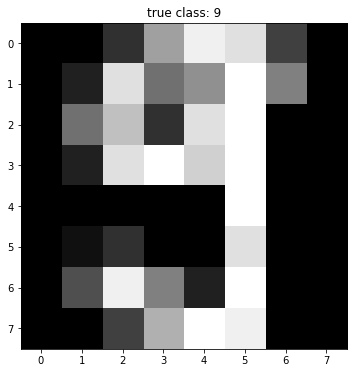

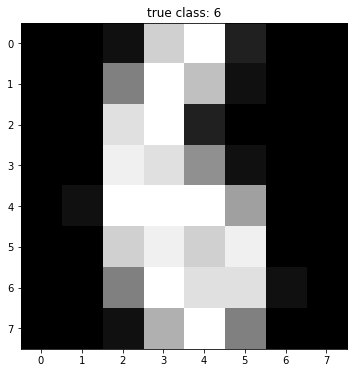

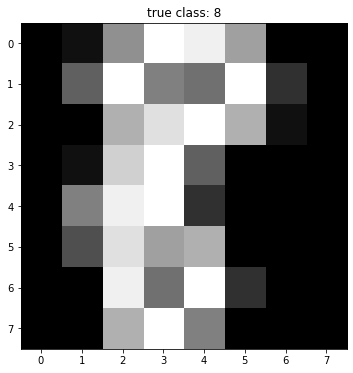

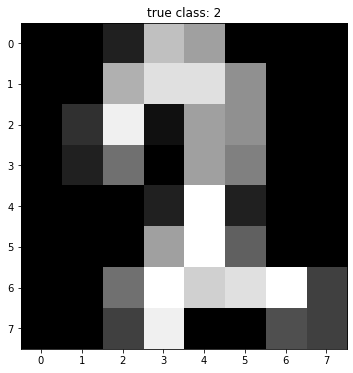

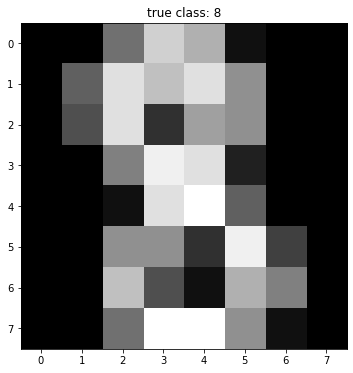

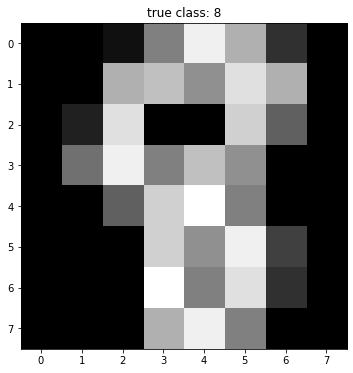

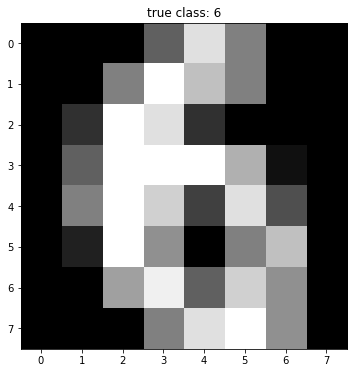

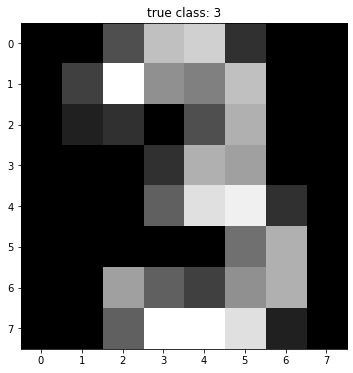

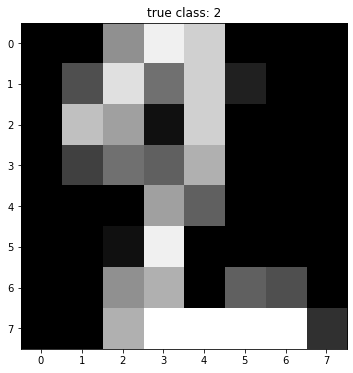

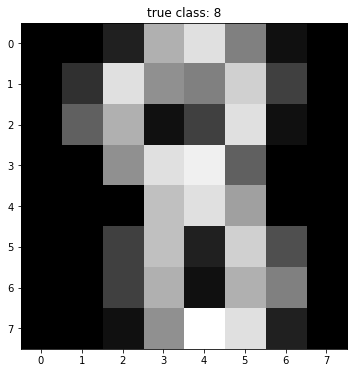

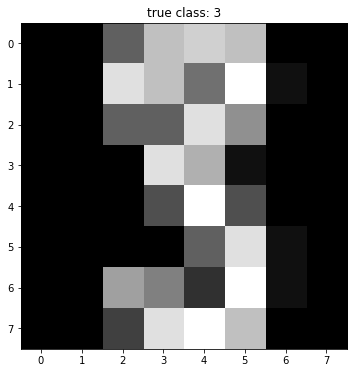

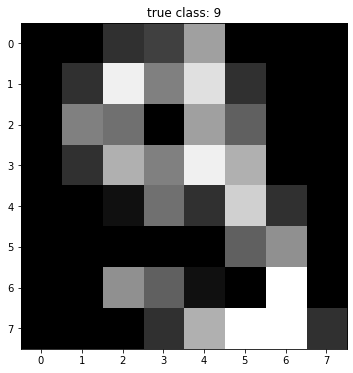

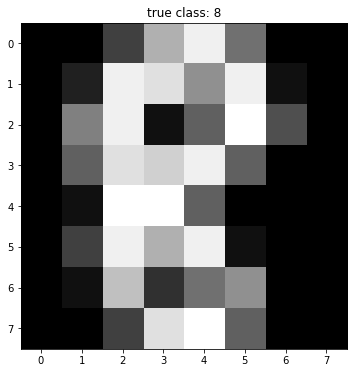

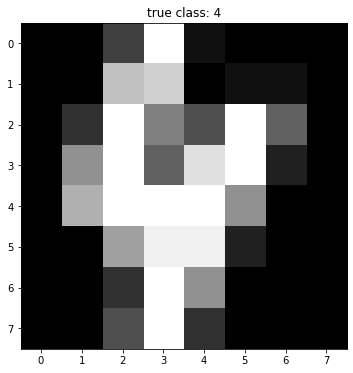

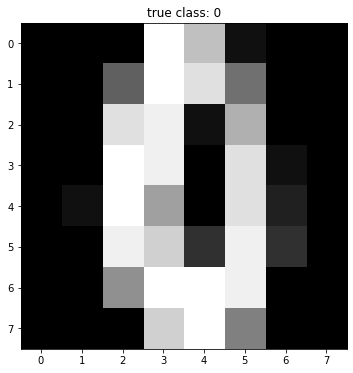

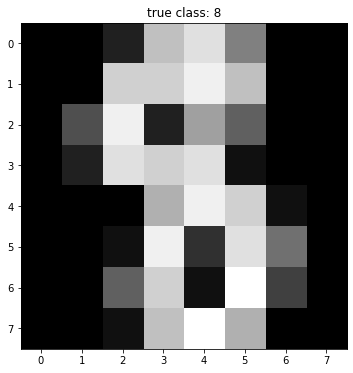

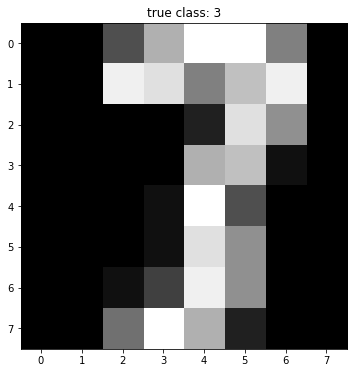

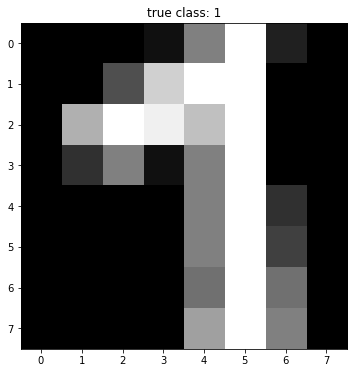

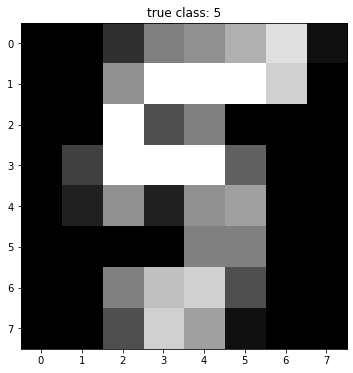

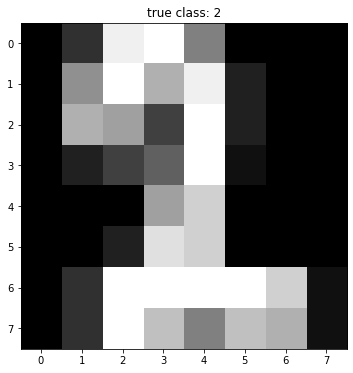

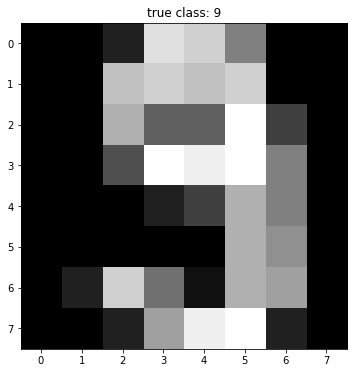

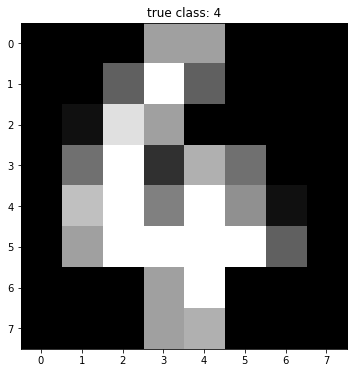

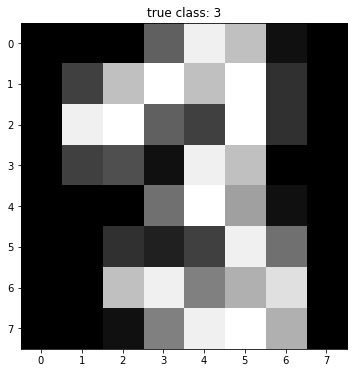

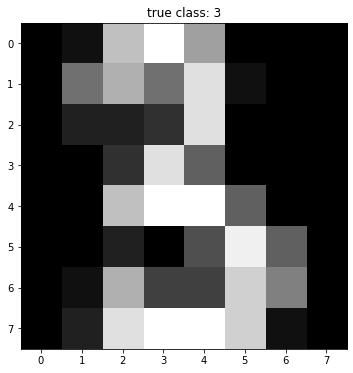

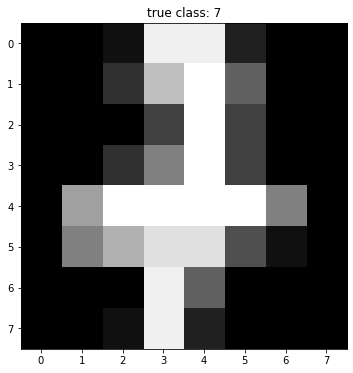

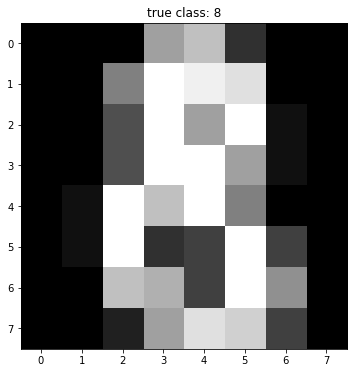

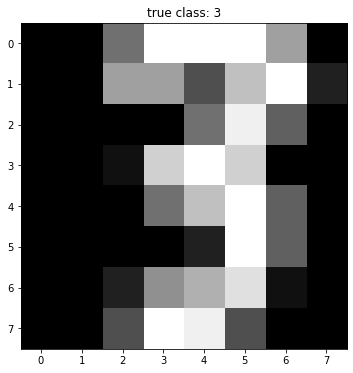

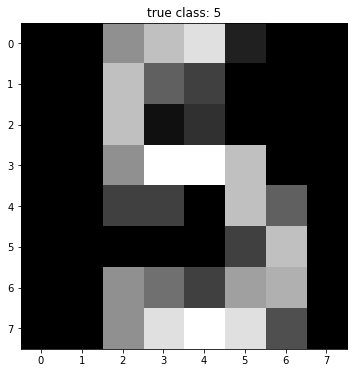

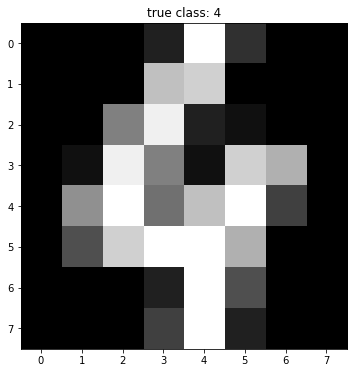

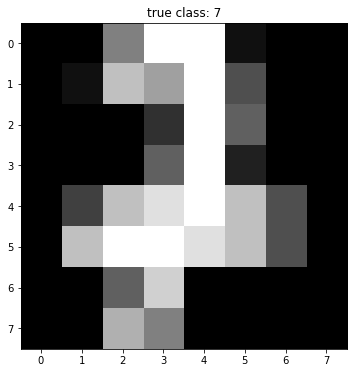

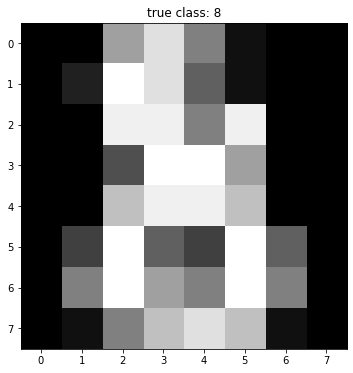

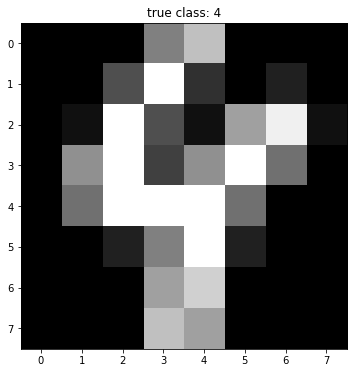

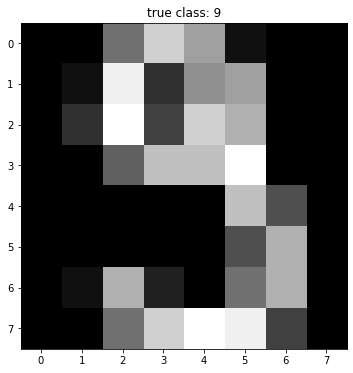

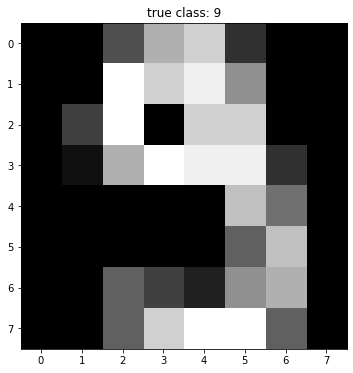

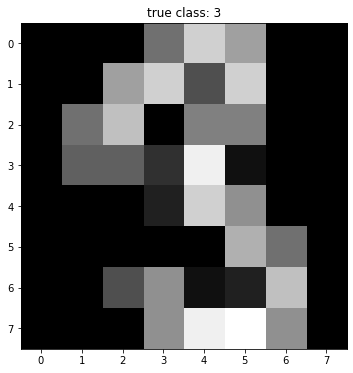

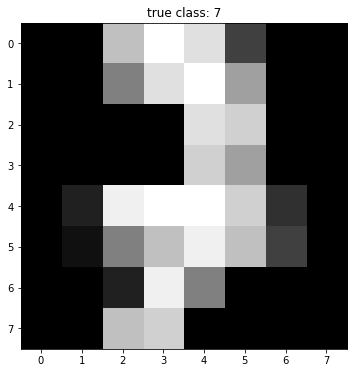

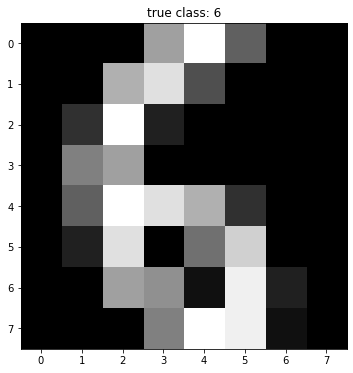

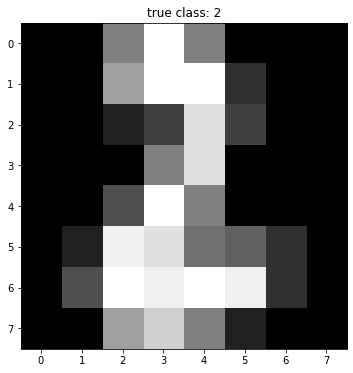

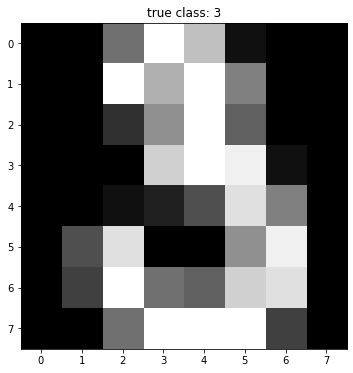

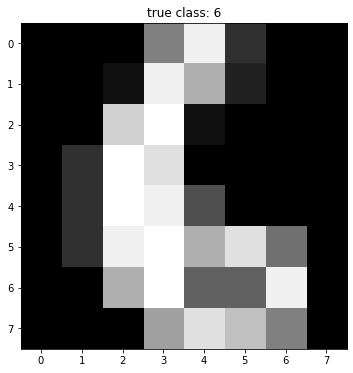

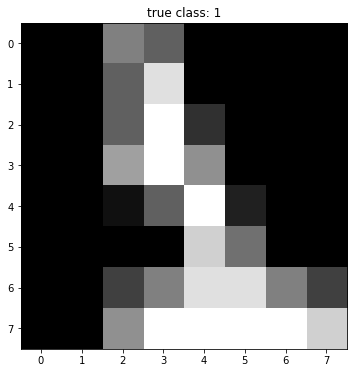

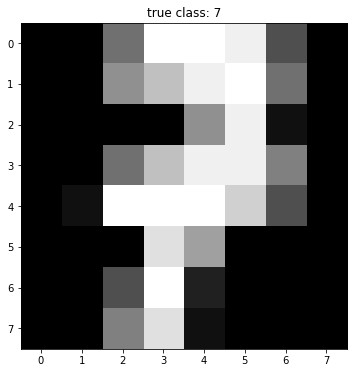

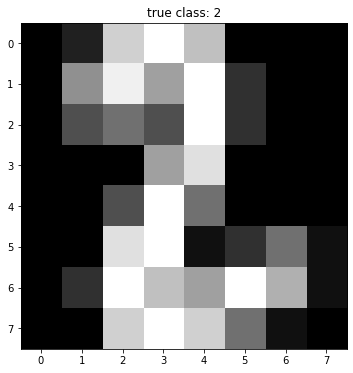

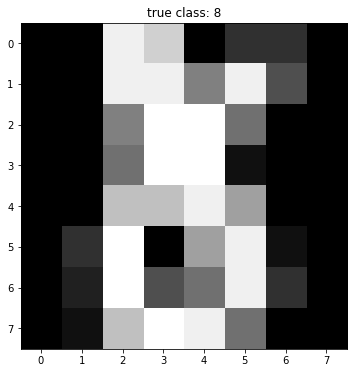

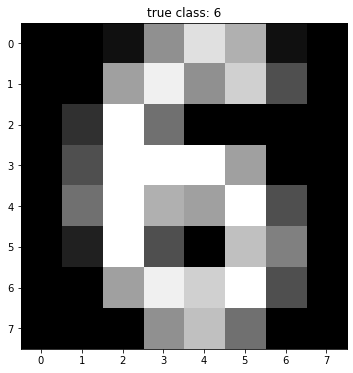

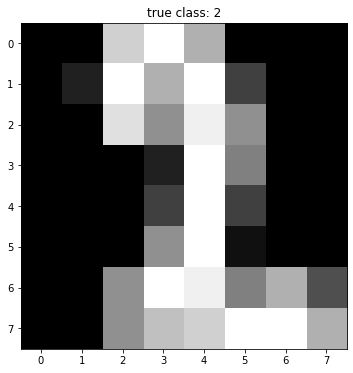

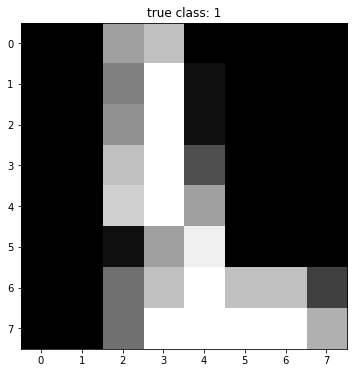

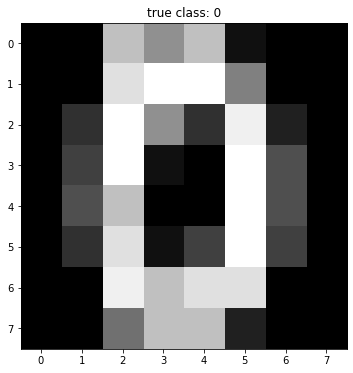

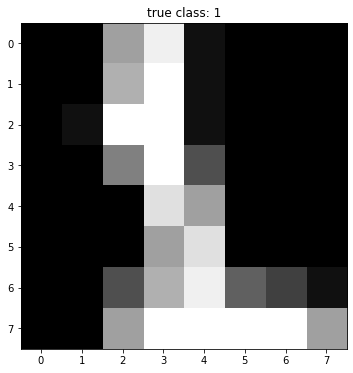

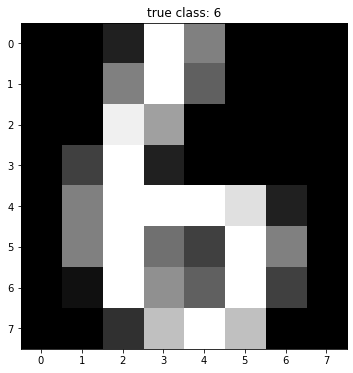

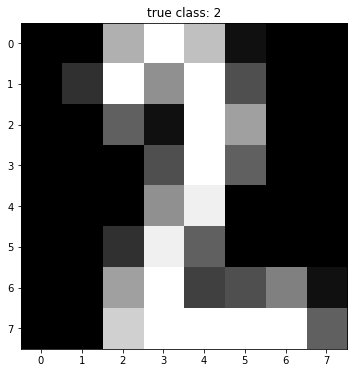

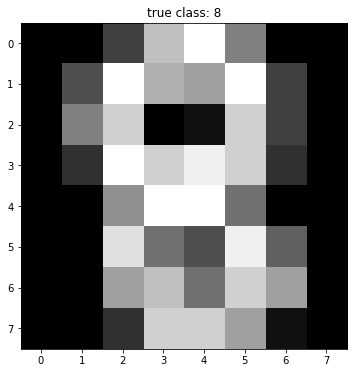

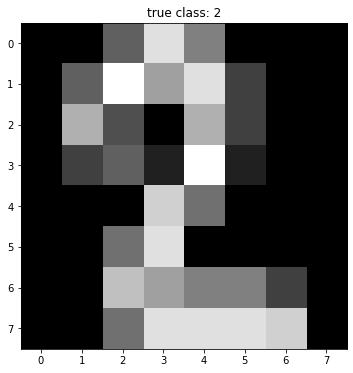

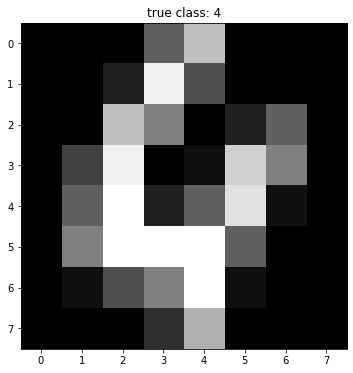

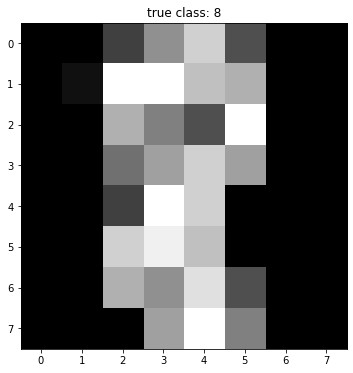

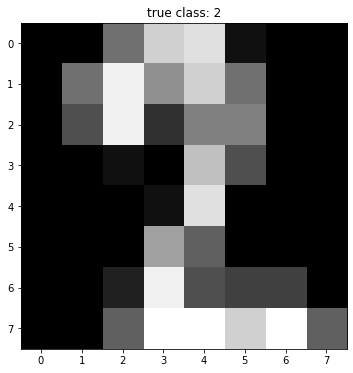

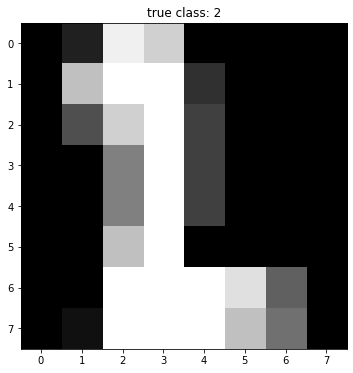

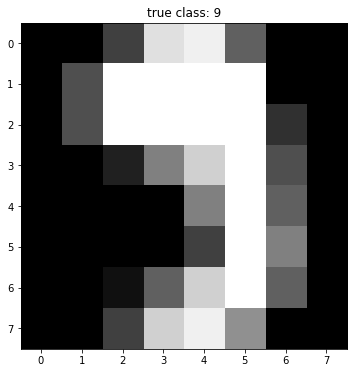

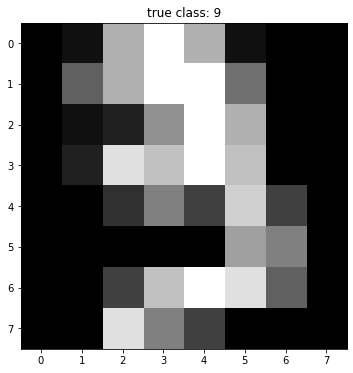

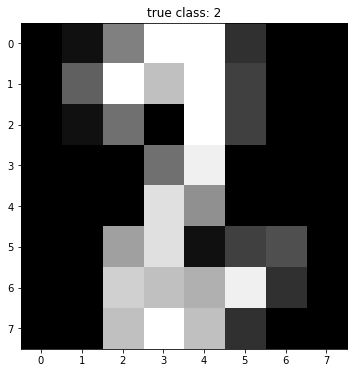

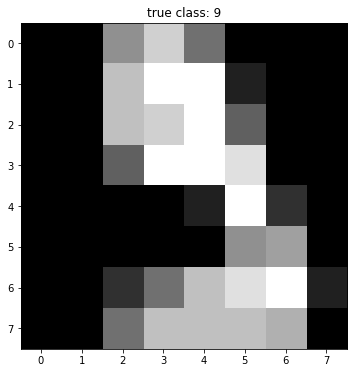

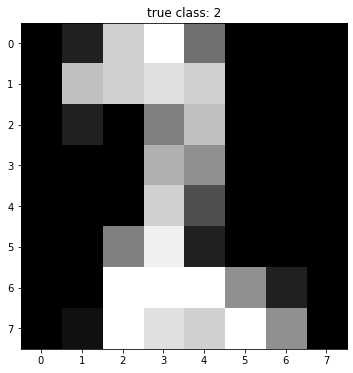

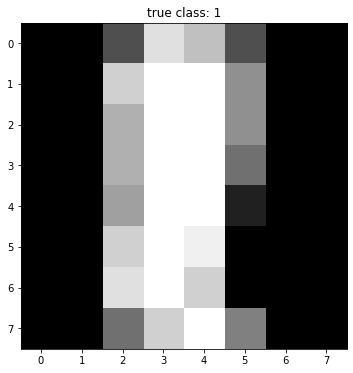

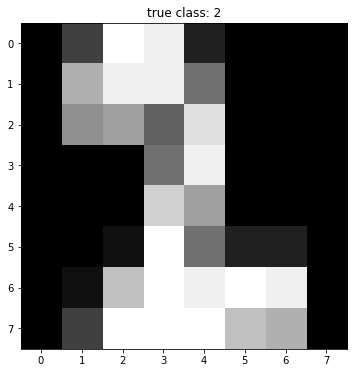

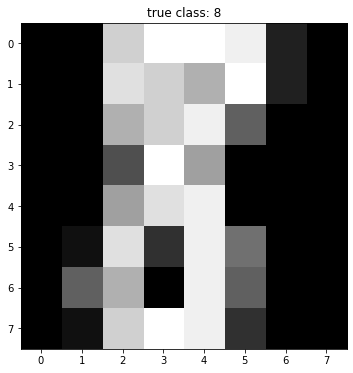

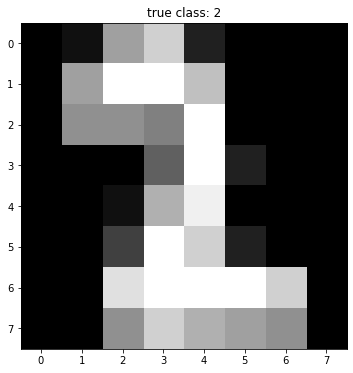

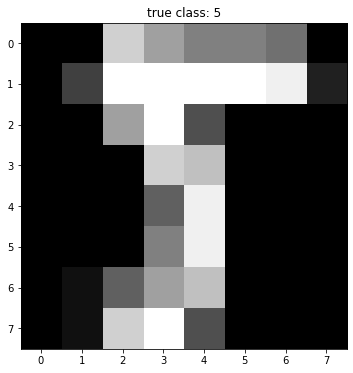

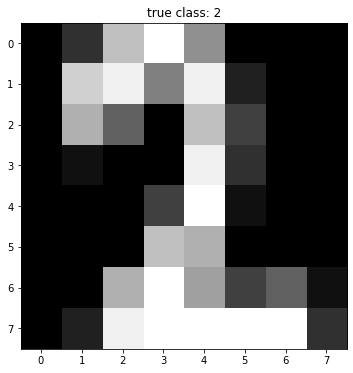

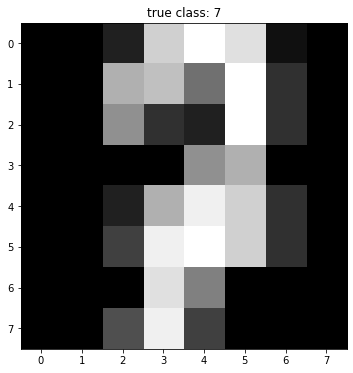

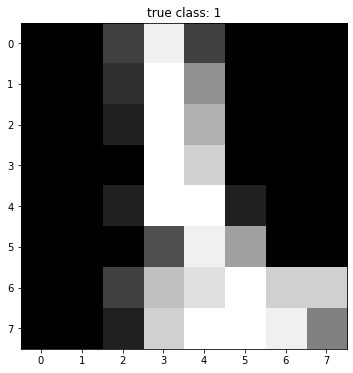

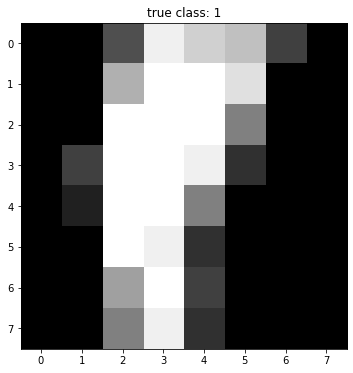

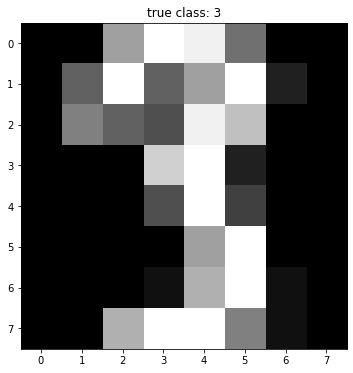

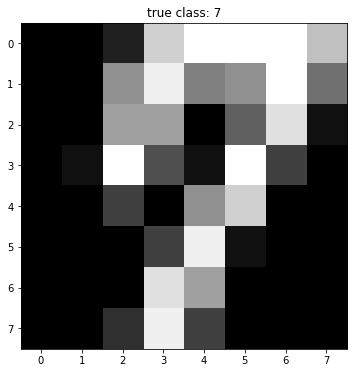

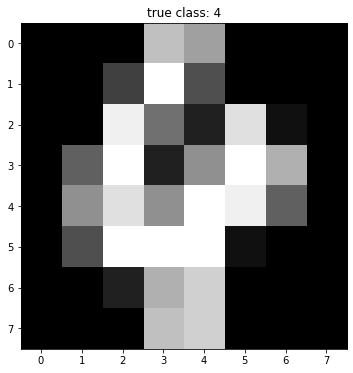

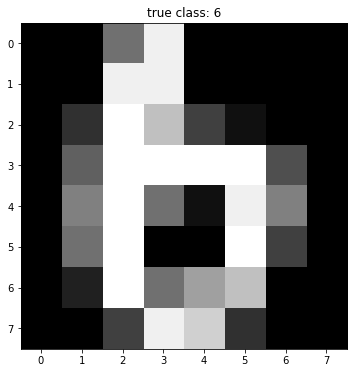

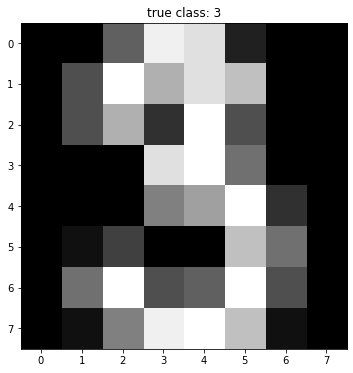

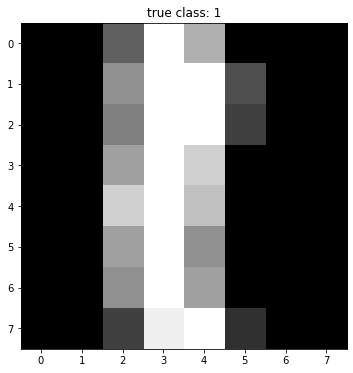

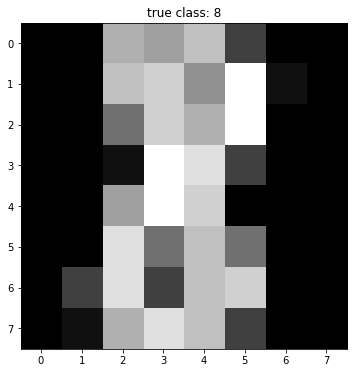

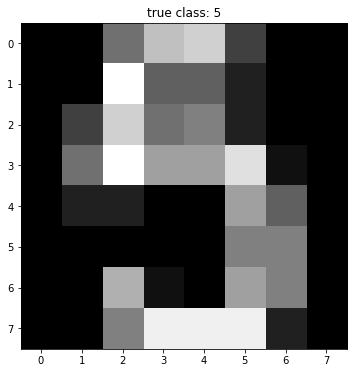

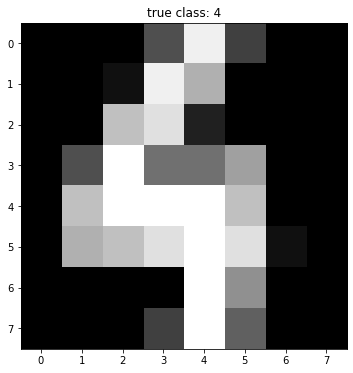

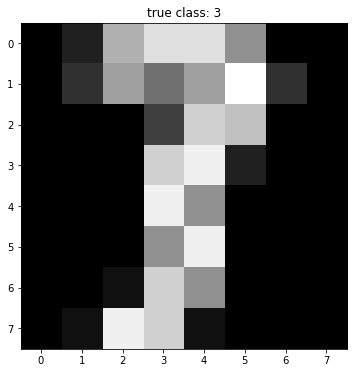

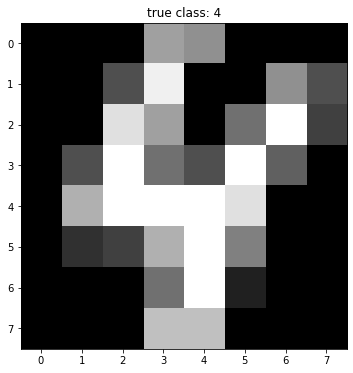

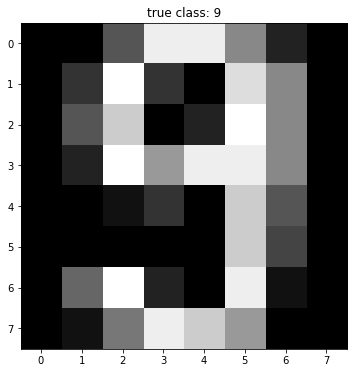

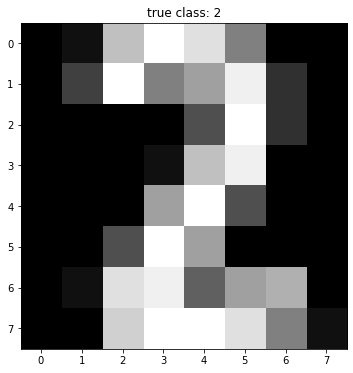

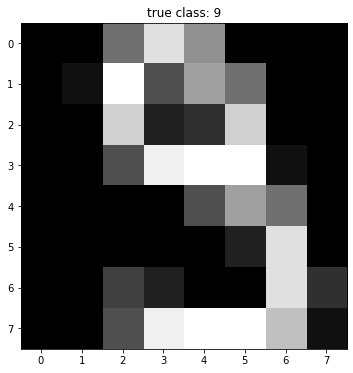

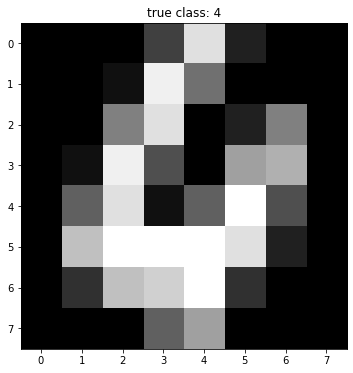

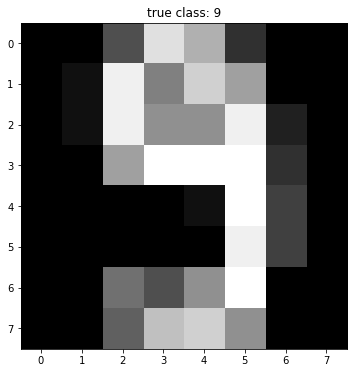

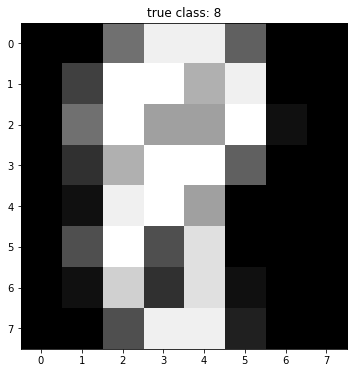

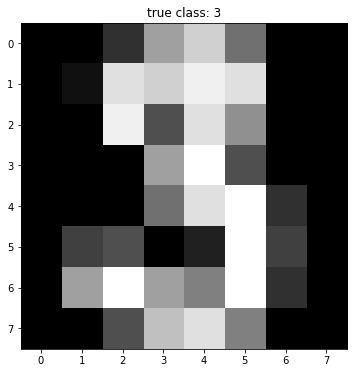

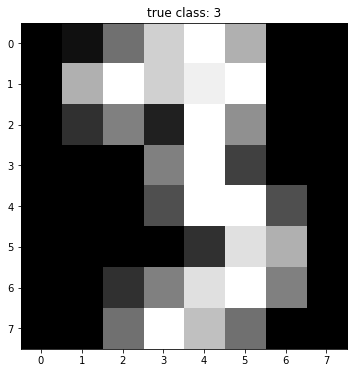

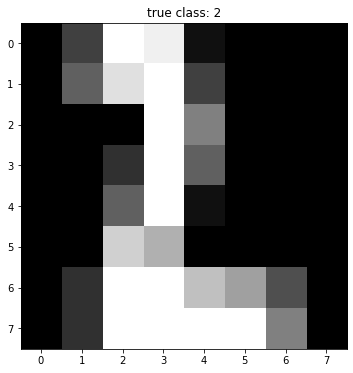

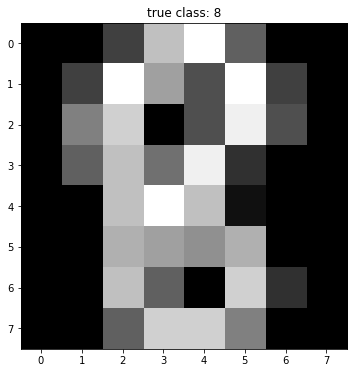

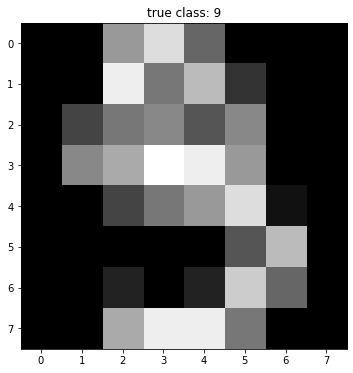

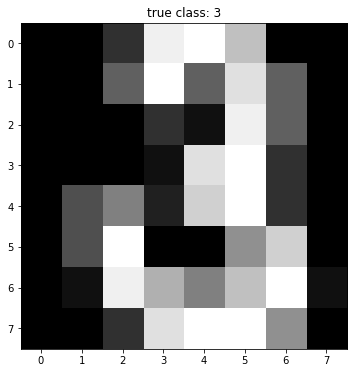

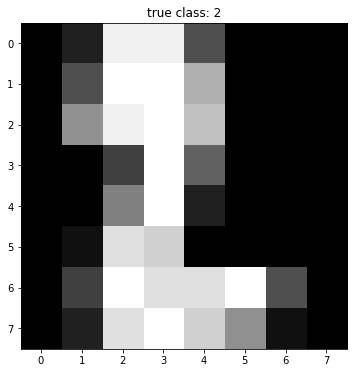

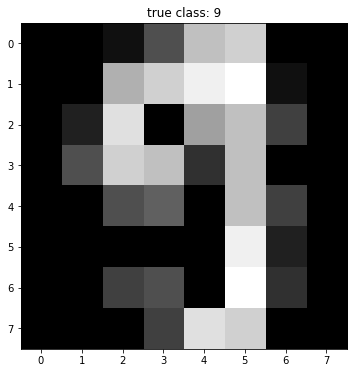

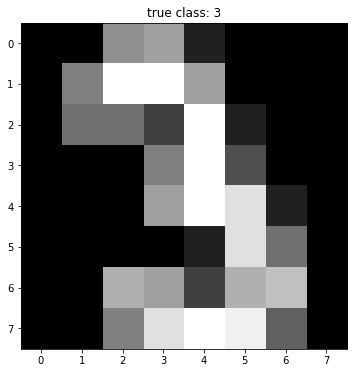

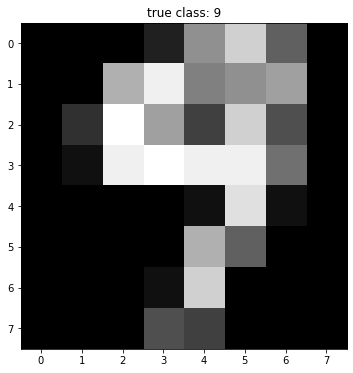

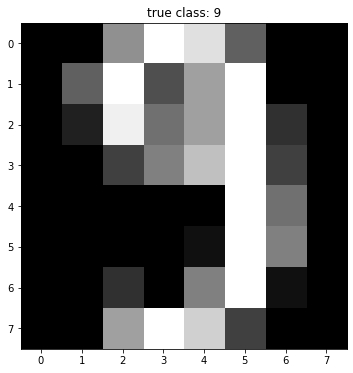

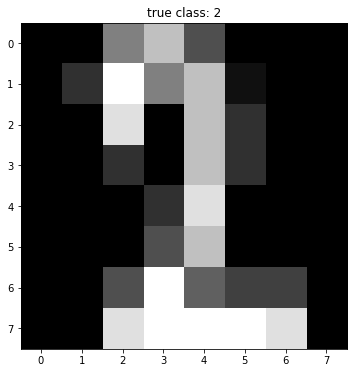

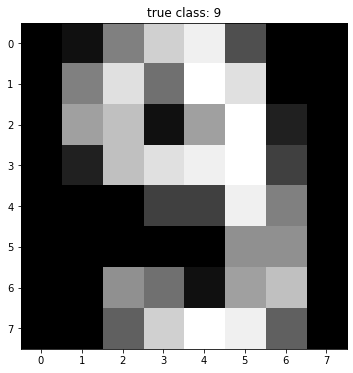

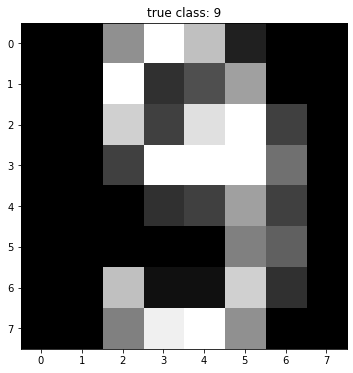

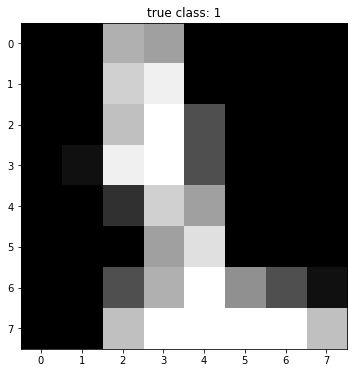

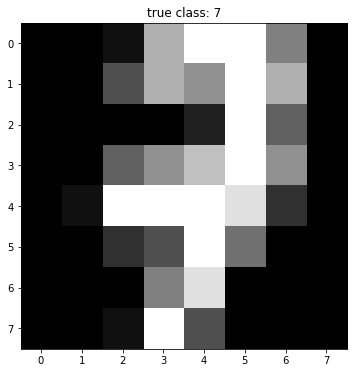

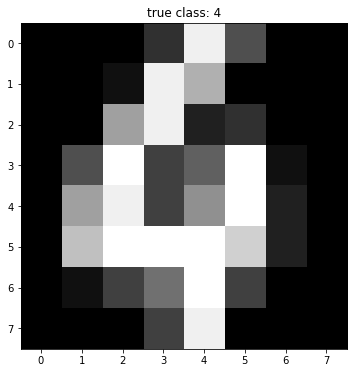

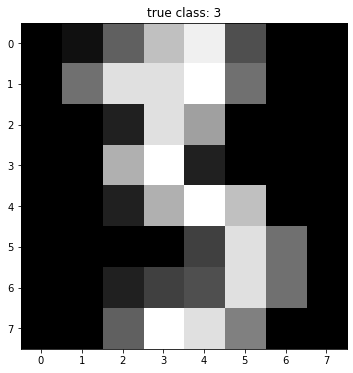

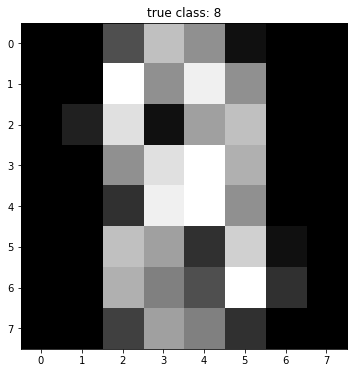

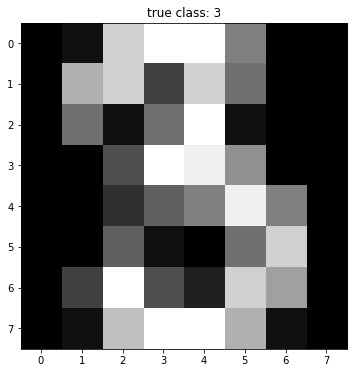

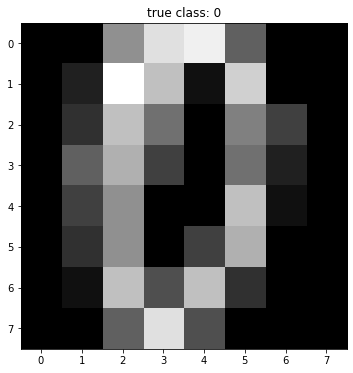

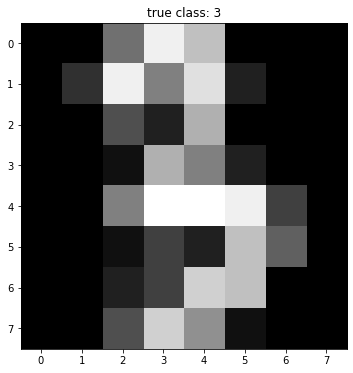

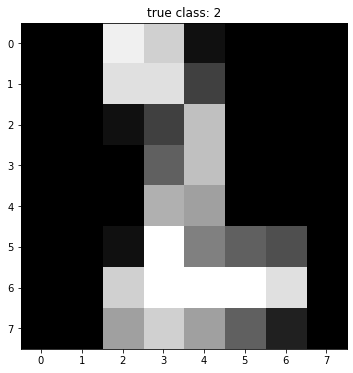

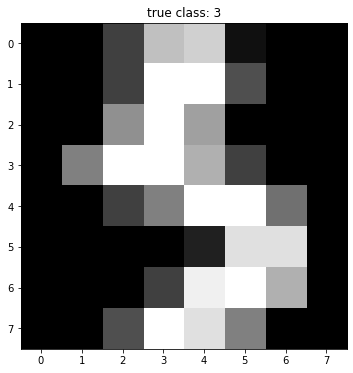

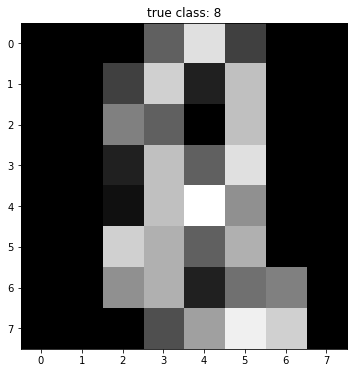

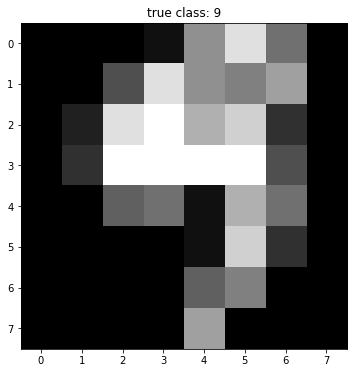

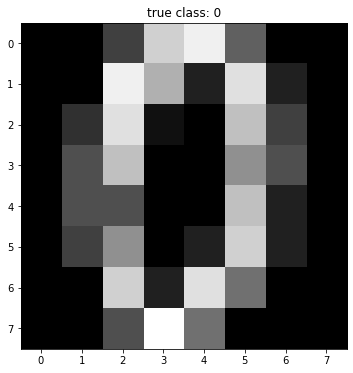

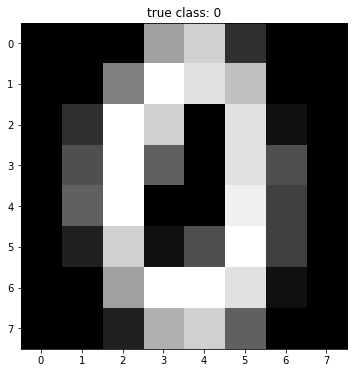

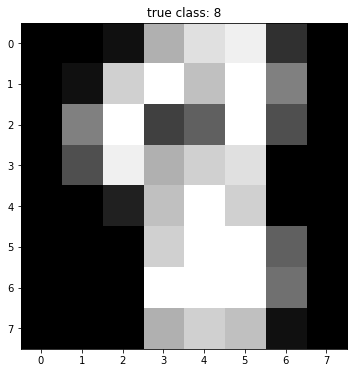

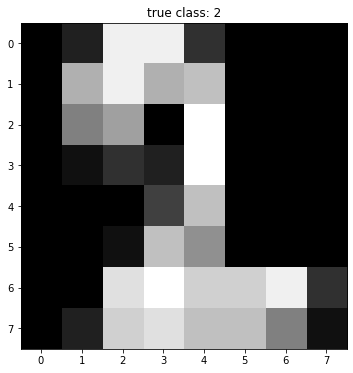

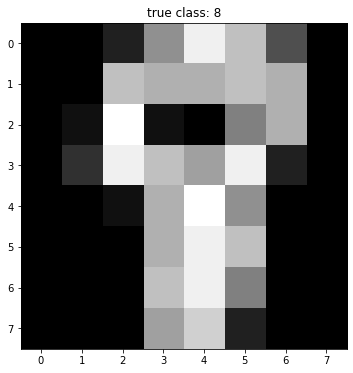

In [59]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data, target, test_size=0.4, random_state=0
)

T = 100

betas = []

for k in range(10):
    mask = y_train == k
    x_train_k = x_train[mask]
    x_train_rest = x_train[~mask]
    y_train_k = y_train[mask]
    y_train_rest = y_train[~mask]

    random_subset = np.random.choice(len(y_train_rest), len(y_train_k))

    X = np.concatenate([x_train_k, x_train_rest], axis=0)
    y = np.concatenate([y_train_k, y_train_rest], axis=0)

    shuffle = np.random.permutation(len(X))
    X = X[shuffle]
    y = y[shuffle]

    mask = y == k
    y[mask] = 1
    y[~mask] = -1

    beta = omp_regression(X, y, T)

    # append beta(t = T)
    betas.append(beta[:,-1])
    

betas = np.array(betas)

responses = (betas*x_test[:,np.newaxis,:]).sum(axis=2)

# predicted digit values for each instance
predicted = np.argmax(responses, axis=1)

# True or False array for which instances are unknown
unknowns = np.all(responses < 0, axis=1)

# assign unknown instances to -1
predicted[unknowns] = -1

# features and targets for unknown instances
unknown = x_test[unknowns]
unknown_target = y_test[unknowns]

print(f"total error: {np.mean(predicted != y_test):.3f}")

pairs, counts = np.unique(np.stack((predicted, y_test)).T, axis=0, return_counts=True)


confusion_matrix = np.zeros((11,11))
for pair, count in zip(pairs, counts):
    # +1 because first row/colum = unknown
    confusion_matrix[pair[0]+1, pair[1]+1] = count

for i in range(-1,10):
    if np.sum(y_test == i) == 0:
        continue
    confusion_matrix[:,i+1] /= np.sum(y_test == i)

target_names = np.array(["unknown", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
# display as Pandas DataFrame
def fade_zeros(s):
    return ["color: lightgray" if (v == 0) else "color: black" for v in s]

print("confusion matrix\n(percentages in a column sum up to 100%)")
display(
    pd.DataFrame(data=confusion_matrix[:, :]*100, index=target_names, columns=target_names)
    .rename_axis("true", axis="columns")
    .rename_axis("predicted", axis="rows")
    .style.apply(fade_zeros)
    .format("{0:.2f}%")
)

for x, y in zip(unknown, unknown_target):
    plt.figure(figsize=(6,6))
    plt.imshow(x.reshape(8,8), cmap="gray")
    plt.title(f"true class: {y}")
    plt.show()